In [2]:
from google.colab import drive

# This will prompt you to click a link and get an authorization code
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [3]:

import pandas as pd
import os

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.signal import find_peaks
import numpy as np

os.chdir("/content/gdrive/MyDrive/DMP")
pd.set_option("display.precision", 2)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/DMP'

In [ ]:

import pandas as pd

people = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']
columns_needed = ["Time[s]", "Delta_Time","MET", "Activity"]


data = []
for person in people:
    df = pd.read_pickle("merged_dataset/{0}/ALL.pkl".format(person))
    df_subset = df[columns_needed]
    df_subset['Person'] = person
    data.append(df_subset)


print(data[0])


                     Time[s]      Delta_Time   MET  Activity Person
Time                                                               
2021-12-03 16:58:51      1.0 0 days 00:00:00  1.31       1.0     P1
2021-12-03 16:58:52      2.0 0 days 00:00:01  1.31       1.0     P1
2021-12-03 16:58:53      3.0 0 days 00:00:02  1.52       1.0     P1
2021-12-03 16:58:54      4.0 0 days 00:00:03  1.63       1.0     P1
2021-12-03 16:58:55      5.0 0 days 00:00:04  1.56       1.0     P1
...                      ...             ...   ...       ...    ...
2021-12-03 17:28:48   1798.0 0 days 00:29:57  5.32       5.0     P1
2021-12-03 17:28:49   1799.0 0 days 00:29:58  5.11       5.0     P1
2021-12-03 17:28:50   1800.0 0 days 00:29:59  4.46       5.0     P1
2021-12-03 17:28:51   1801.0 0 days 00:30:00  4.12       5.0     P1
2021-12-03 17:28:52   1802.0 0 days 00:30:01  4.43       5.0     P1

[1802 rows x 5 columns]


<ipython-input-4-44f9bae63a50>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Person'] = person
<ipython-input-4-44f9bae63a50>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Person'] = person
<ipython-input-4-44f9bae63a50>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [5]:
data[0]

Time[s]      Delta_Time   MET  Activity Person
Time                                                               
2021-12-03 16:58:51      1.0 0 days 00:00:00  1.31       1.0     P1
2021-12-03 16:58:52      2.0 0 days 00:00:01  1.31       1.0     P1
2021-12-03 16:58:53      3.0 0 days 00:00:02  1.52       1.0     P1
2021-12-03 16:58:54      4.0 0 days 00:00:03  1.63       1.0     P1
2021-12-03 16:58:55      5.0 0 days 00:00:04  1.56       1.0     P1
...                      ...             ...   ...       ...    ...
2021-12-03 17:28:48   1798.0 0 days 00:29:57  5.32       5.0     P1
2021-12-03 17:28:49   1799.0 0 days 00:29:58  5.11       5.0     P1
2021-12-03 17:28:50   1800.0 0 days 00:29:59  4.46       5.0     P1
2021-12-03 17:28:51   1801.0 0 days 00:30:00  4.12       5.0     P1
2021-12-03 17:28:52   1802.0 0 days 00:30:01  4.43       5.0     P1

[1802 rows x 5 columns]

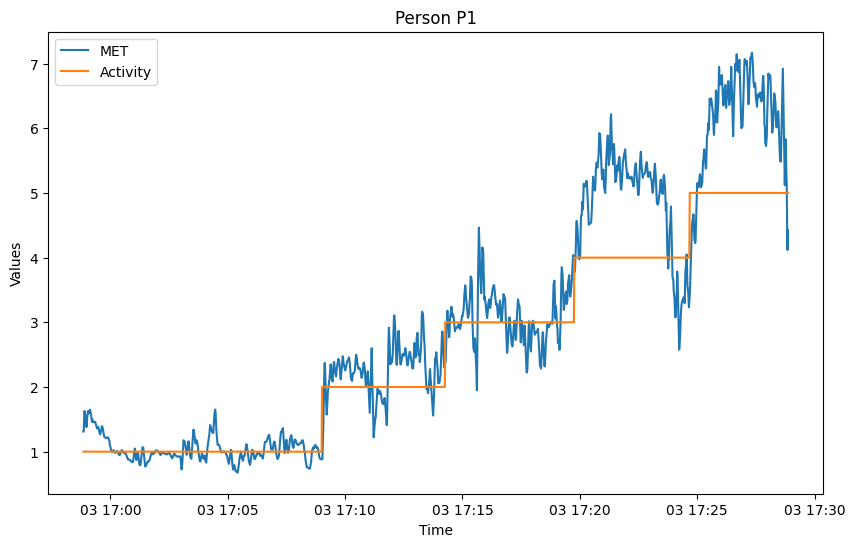

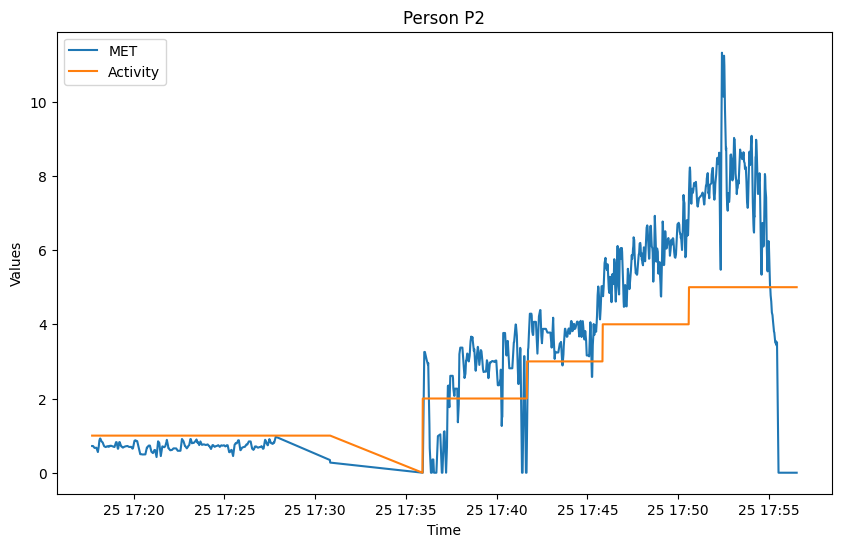

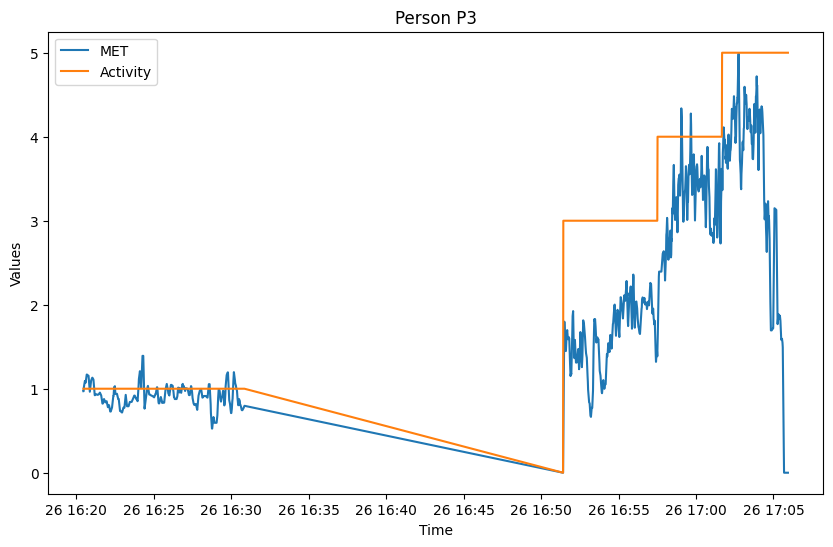

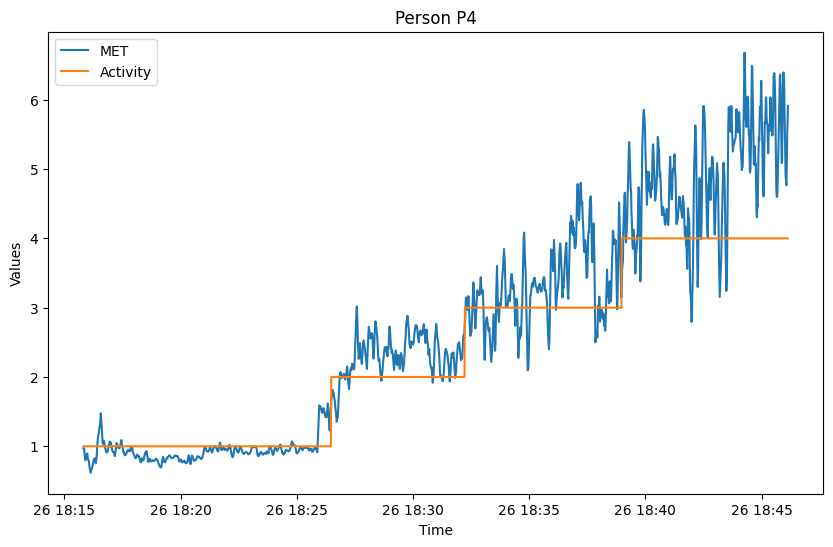

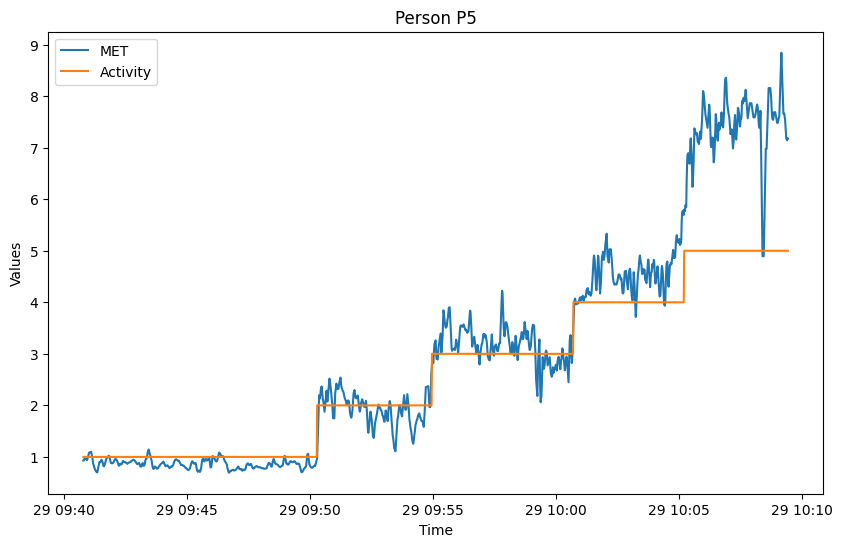

In [6]:
import matplotlib.pyplot as plt

# Iterate over the data list
for i, df_subset in enumerate(data):
  if i < 5:
    person = people[i]

    # Extract MET and value__bpm columns
    MET = df_subset['MET']
    value_bpm = df_subset['Activity'].ffill()

    # Plot MET and value__bpm
    plt.figure(figsize=(10, 6))
    plt.plot(MET, label='MET')
    plt.plot(value_bpm, label='Activity')
    plt.title(f'Person {person}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


## Feature engineering

In [7]:
columns_needed = [columns_needed[len(columns_needed)-1]]


In [8]:
def generate_features(data, time_lagged_feature=True, statistical_feature=True, time_lags=None, roll_window=10):
    if time_lagged_feature:
        if time_lags is None:
            time_lags = [x for x in range(1, 15, 2)]

        for time_lag in time_lags:
            data[f'Activity_lag_b_{time_lag}'] = data['Activity'].shift(time_lag)
            data[f'Activity_lag_b_{time_lag}'].fillna(method='bfill', inplace=True)

            # Now create the forward lagged features
            data[f'Activity_lag_f_{time_lag}'] = data['Activity'].shift(-time_lag)
            data[f'Activity_lag_f_{time_lag}'].fillna(method='ffill', inplace=True)

    if statistical_feature:
        data['Activity_mean'] = data['Activity'].rolling(window=roll_window).mean()

    return data


time_lags = [x for x in range(1, 15, 2)]
for i in range(len(data)):
    data[i] = generate_features(data[i], time_lagged_feature=True, time_lags=time_lags)

columns_needed = columns_needed + [col for col in data[0].columns if 'lag' in col]
for i in range(len(data)):
        data[i] = generate_features(data[i], statistical_feature=True, roll_window=20)

columns_needed = columns_needed + ['Activity_mean']



<ipython-input-8-f4efaba043eb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Activity_lag_b_{time_lag}'] = data['Activity'].shift(time_lag)
<ipython-input-8-f4efaba043eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Activity_lag_b_{time_lag}'].fillna(method='bfill', inplace=True)
<ipython-input-8-f4efaba043eb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [9]:
columns_needed

['Activity',
 'Activity_lag_b_1',
 'Activity_lag_f_1',
 'Activity_lag_b_3',
 'Activity_lag_f_3',
 'Activity_lag_b_5',
 'Activity_lag_f_5',
 'Activity_lag_b_7',
 'Activity_lag_f_7',
 'Activity_lag_b_9',
 'Activity_lag_f_9',
 'Activity_lag_b_11',
 'Activity_lag_f_11',
 'Activity_lag_b_13',
 'Activity_lag_f_13',
 'Activity_mean']

## Model training

### Train/test splitting

In [10]:
concatenated_data = pd.concat(data, axis=0)

concatenated_data = concatenated_data.dropna()

X_data = concatenated_data[columns_needed].copy()
X_data = X_data.to_numpy()

Y_data = concatenated_data['MET']
Y_data = Y_data.to_numpy()
people = concatenated_data['Person']

In [11]:
normalizer = MinMaxScaler()
X_data = normalizer.fit_transform(X_data)

### XGBoost with cross validation

#### Cross validation

In [12]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.9 MB/s eta 0:00:00


In [13]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold

# Define the parameters grid
parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create XGBRegressor model
model = XGBRegressor(colsample_bytree=0.56, subsample=0.3, min_child_weight=0.6)

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search with custom CV splitter
grid_search = GridSearchCV(model, parameters_grid, cv=group_kfold.split(X_data, Y_data, people), scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


Best parameters found:
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
Best mean absolute error found: 0.7623895419820969


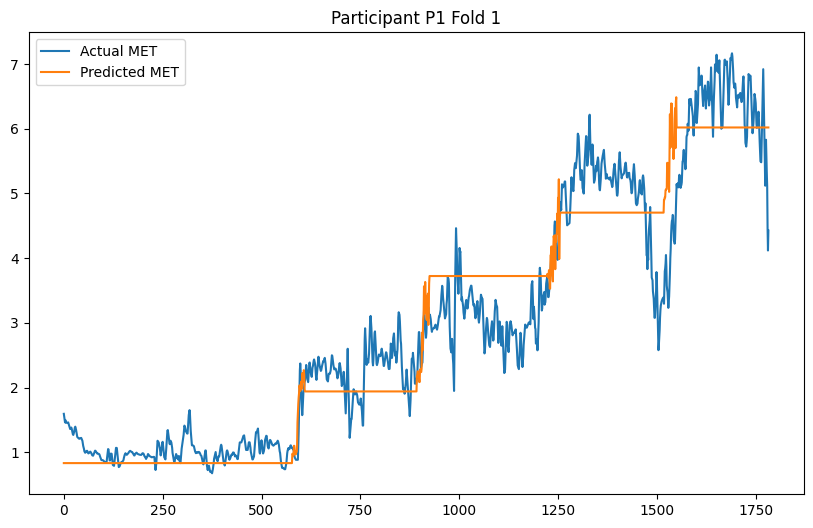

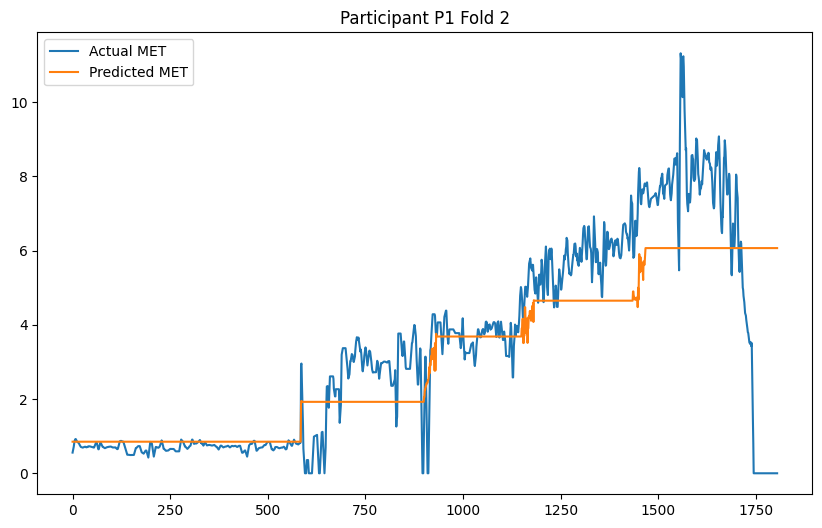

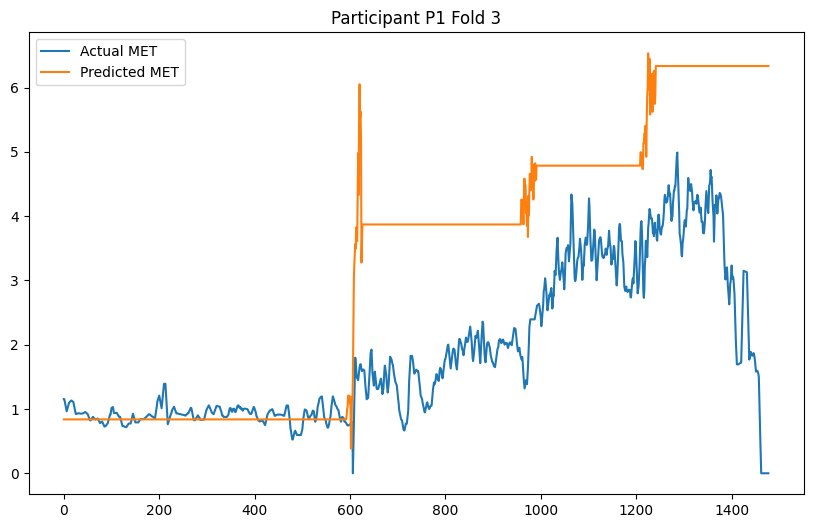

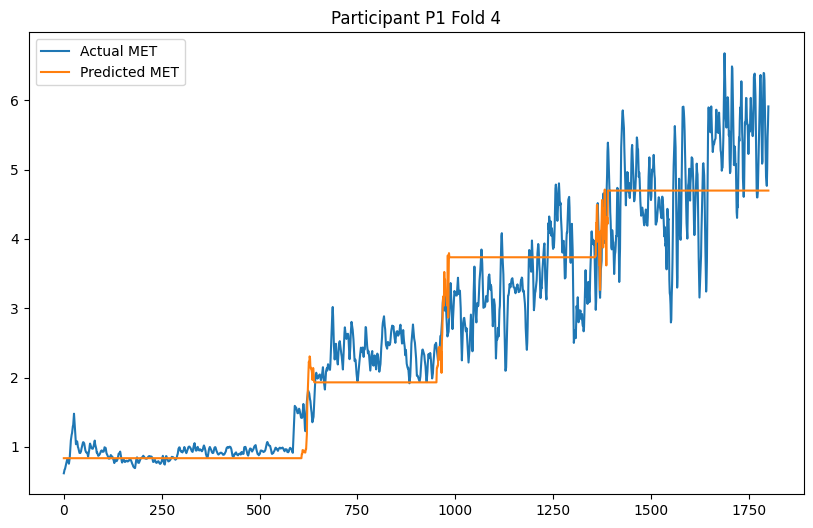

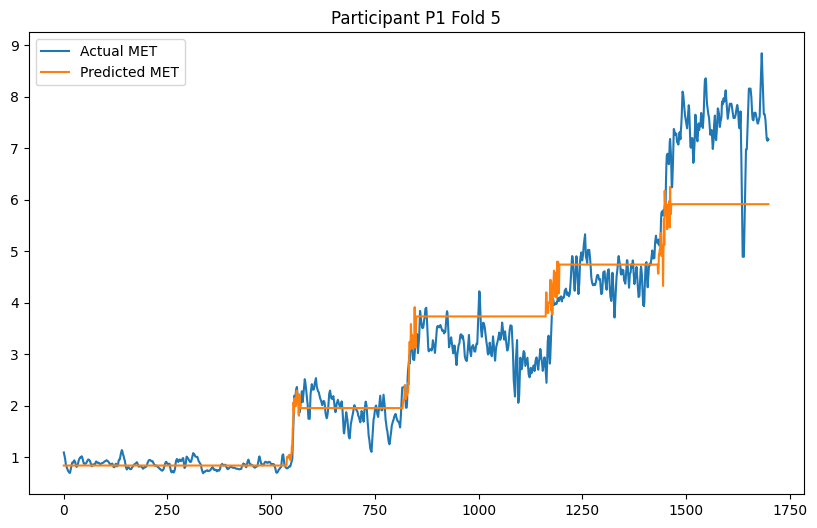

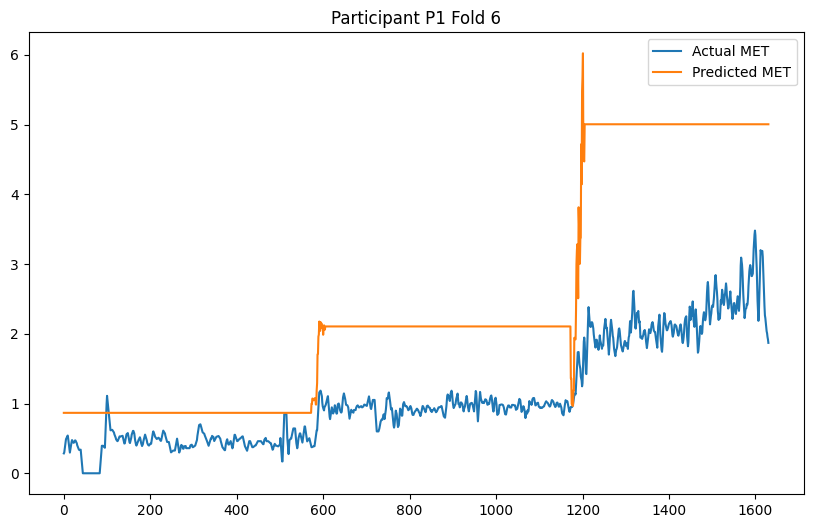

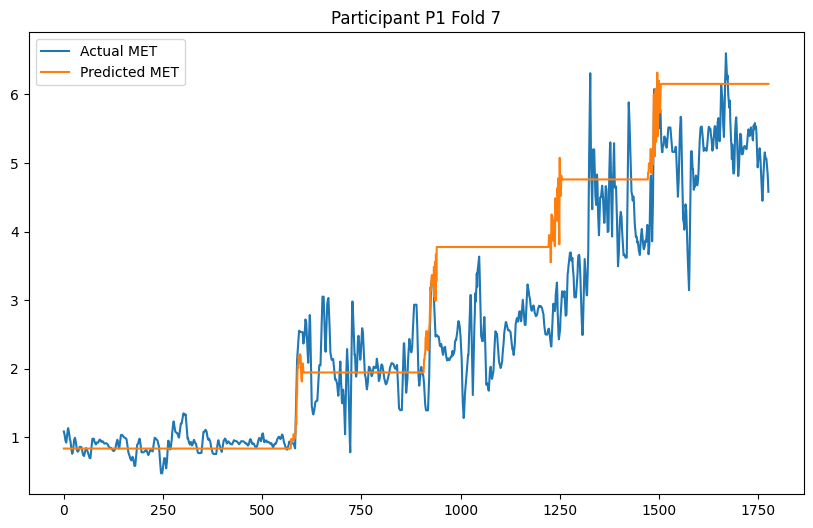

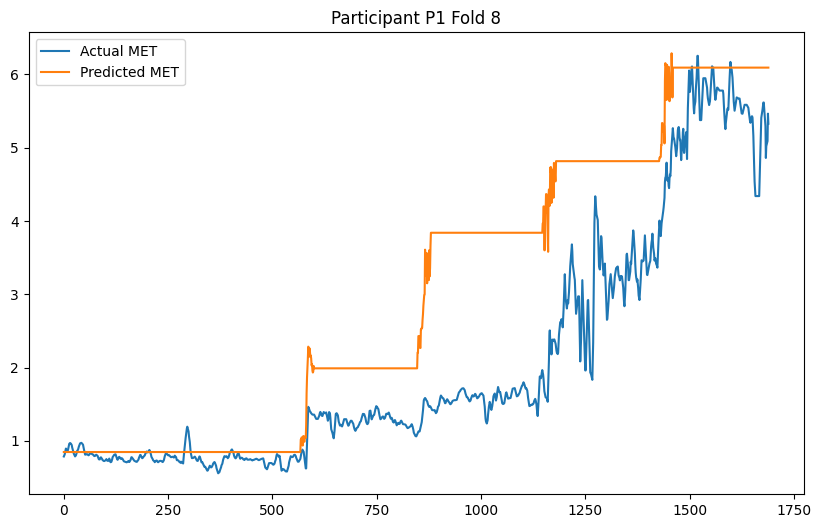

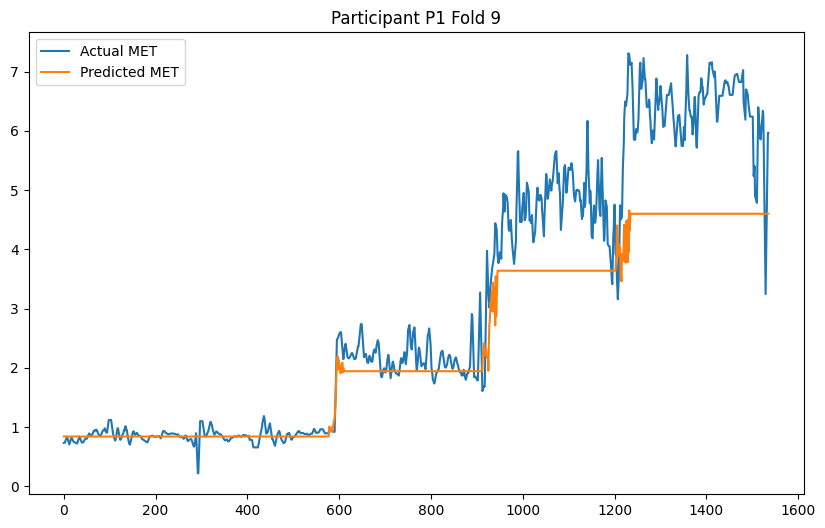

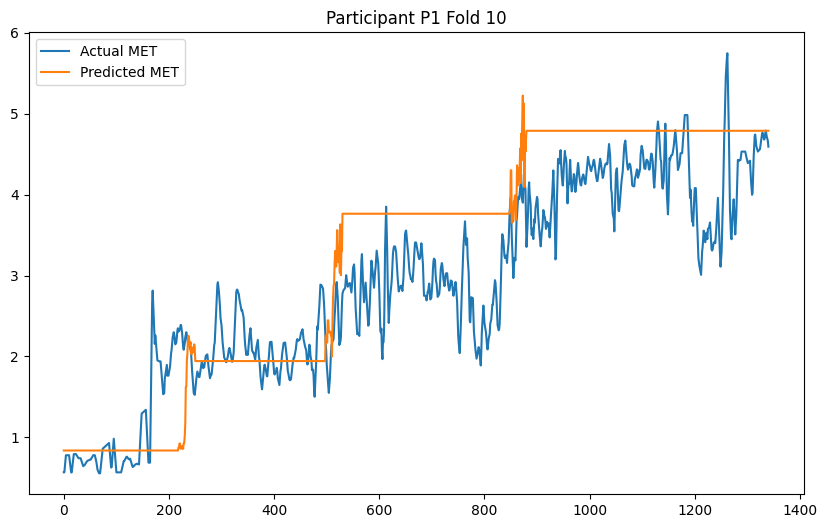

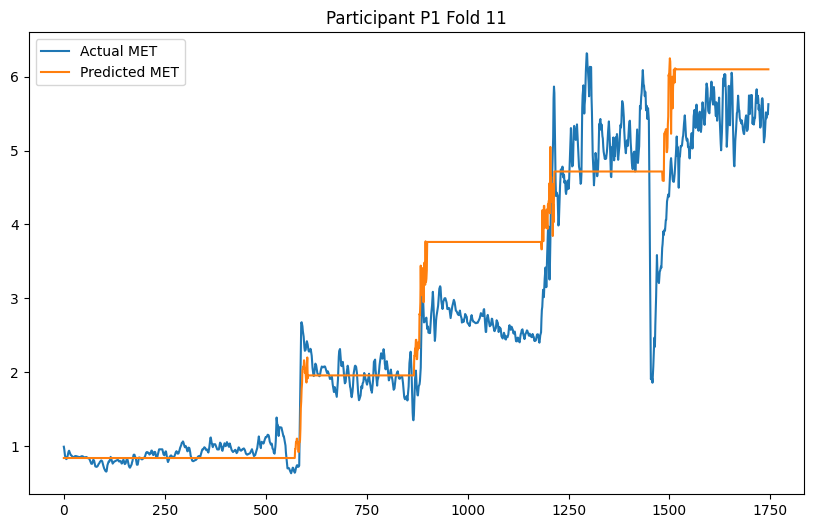

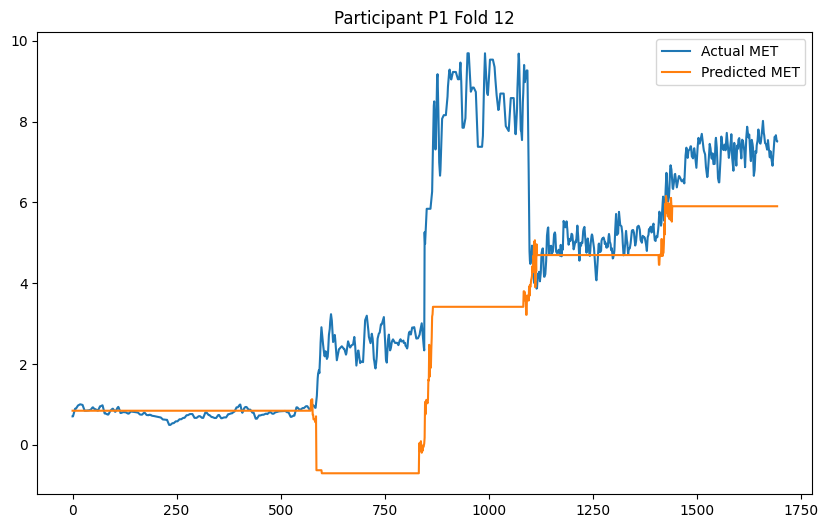

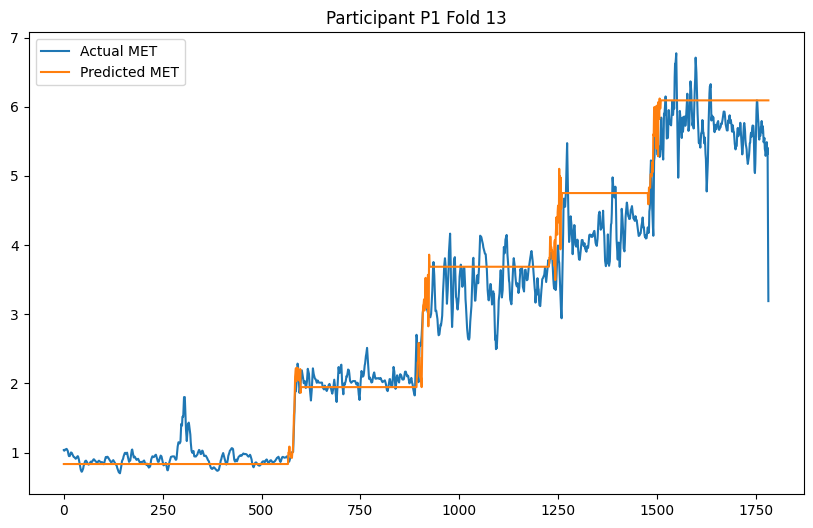

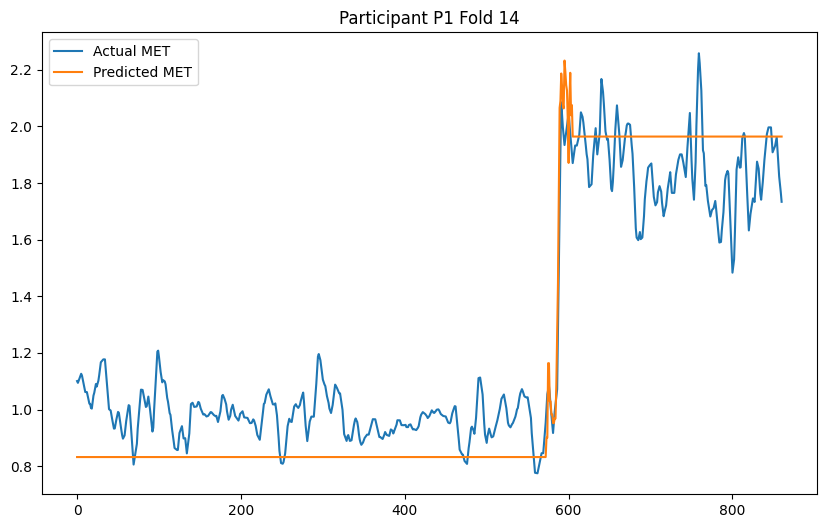

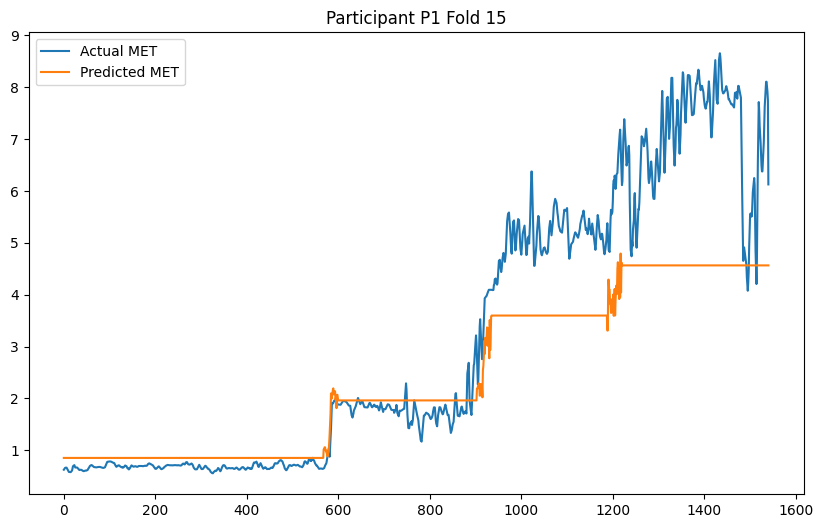

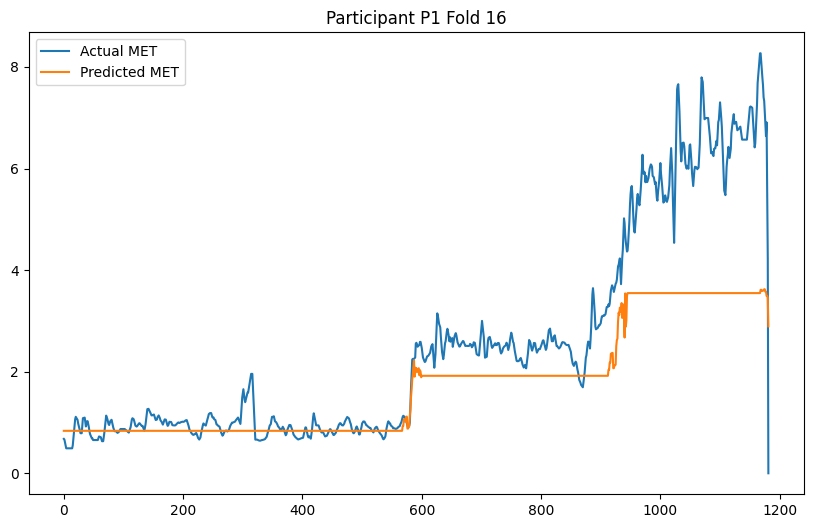

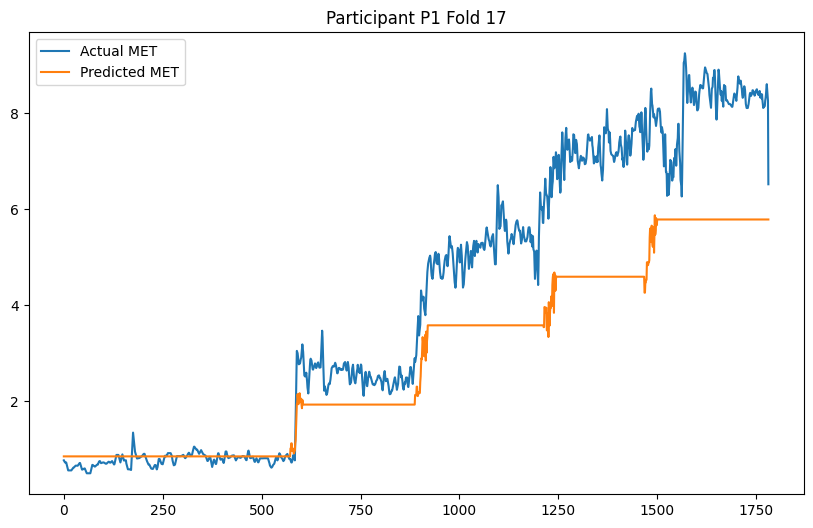

In [14]:
import matplotlib.pyplot as plt
# Import MAE
from sklearn.metrics import mean_absolute_error
# Plot the actual MET and the predicted MET for participants
# print(X_data, Y_data, participants)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    # print(train_index, test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant {0} Fold {1}'.format(people[fold], fold+1))
    plt.legend()
    plt.show()

In [110]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer, mean_absolute_error

# Define the parameters grid
parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create CatBoostRegressor model
model = CatBoostRegressor()

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search
grid_search = GridSearchCV(model, parameters_grid, cv=group_kfold.split(X_data, Y_data, people), scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


0:	learn: 2.1419360	total: 4.07ms	remaining: 2.03s
1:	learn: 2.1279800	total: 7.96ms	remaining: 1.98s
2:	learn: 2.1142836	total: 10.8ms	remaining: 1.78s
3:	learn: 2.1007477	total: 13.6ms	remaining: 1.69s
4:	learn: 2.0874048	total: 16.5ms	remaining: 1.63s
5:	learn: 2.0741761	total: 19.2ms	remaining: 1.58s
6:	learn: 2.0611310	total: 22.2ms	remaining: 1.57s
7:	learn: 2.0482981	total: 26.9ms	remaining: 1.66s
8:	learn: 2.0356363	total: 29.6ms	remaining: 1.62s
9:	learn: 2.0230805	total: 32.5ms	remaining: 1.59s
10:	learn: 2.0107191	total: 35.3ms	remaining: 1.57s
11:	learn: 1.9985436	total: 38ms	remaining: 1.55s
12:	learn: 1.9865143	total: 40.8ms	remaining: 1.53s
13:	learn: 1.9746875	total: 43.6ms	remaining: 1.51s
14:	learn: 1.9630371	total: 46.3ms	remaining: 1.5s
15:	learn: 1.9515065	total: 49.1ms	remaining: 1.48s
16:	learn: 1.9401116	total: 51.8ms	remaining: 1.47s
17:	learn: 1.9288764	total: 54.6ms	remaining: 1.46s
18:	learn: 1.9177950	total: 57.3ms	remaining: 1.45s
19:	learn: 1.9069333	tota

Learning rate set to 0.068306
0:	learn: 2.0694450	total: 5.66ms	remaining: 5.66s
1:	learn: 1.9755260	total: 11ms	remaining: 5.48s
2:	learn: 1.8903655	total: 16ms	remaining: 5.3s
3:	learn: 1.8137527	total: 20.7ms	remaining: 5.15s
4:	learn: 1.7436408	total: 25.5ms	remaining: 5.08s
5:	learn: 1.6806203	total: 30.3ms	remaining: 5.02s
6:	learn: 1.6236047	total: 34.9ms	remaining: 4.95s
7:	learn: 1.5723606	total: 39.5ms	remaining: 4.9s
8:	learn: 1.5268478	total: 44.2ms	remaining: 4.86s
9:	learn: 1.4857852	total: 48.8ms	remaining: 4.83s
10:	learn: 1.4492983	total: 53.7ms	remaining: 4.82s
11:	learn: 1.4167119	total: 58.7ms	remaining: 4.83s
12:	learn: 1.3877807	total: 66.3ms	remaining: 5.03s
13:	learn: 1.3625335	total: 72.3ms	remaining: 5.09s
14:	learn: 1.3398253	total: 77ms	remaining: 5.06s
15:	learn: 1.3200716	total: 82.3ms	remaining: 5.06s
16:	learn: 1.3023314	total: 86.8ms	remaining: 5.02s
17:	learn: 1.2867141	total: 91.5ms	remaining: 4.99s
18:	learn: 1.2730314	total: 96ms	remaining: 4.95s
19

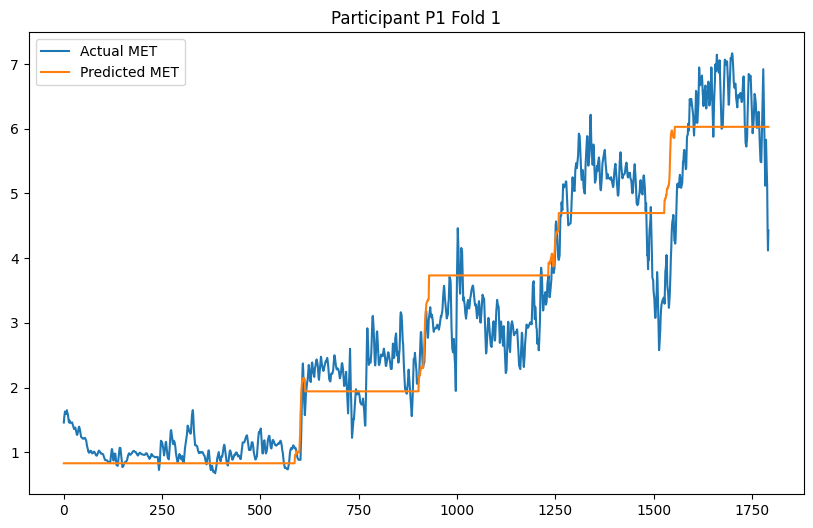

Learning rate set to 0.068293
0:	learn: 2.0055742	total: 5.39ms	remaining: 5.38s
1:	learn: 1.9120783	total: 9.67ms	remaining: 4.82s
2:	learn: 1.8273161	total: 14.3ms	remaining: 4.76s
3:	learn: 1.7503036	total: 19.1ms	remaining: 4.76s
4:	learn: 1.6806769	total: 23.5ms	remaining: 4.68s
5:	learn: 1.6176825	total: 29.8ms	remaining: 4.94s
6:	learn: 1.5607024	total: 35.1ms	remaining: 4.98s
7:	learn: 1.5093379	total: 40.6ms	remaining: 5.03s
8:	learn: 1.4637585	total: 45.4ms	remaining: 5s
9:	learn: 1.4225362	total: 50.2ms	remaining: 4.97s
10:	learn: 1.3857809	total: 55.3ms	remaining: 4.97s
11:	learn: 1.3529053	total: 59.9ms	remaining: 4.93s
12:	learn: 1.3237632	total: 66.6ms	remaining: 5.05s
13:	learn: 1.2982719	total: 70.8ms	remaining: 4.99s
14:	learn: 1.2753237	total: 75.6ms	remaining: 4.96s
15:	learn: 1.2553869	total: 80.4ms	remaining: 4.94s
16:	learn: 1.2374798	total: 85.1ms	remaining: 4.92s
17:	learn: 1.2217277	total: 89.4ms	remaining: 4.88s
18:	learn: 1.2079150	total: 94.2ms	remaining: 4

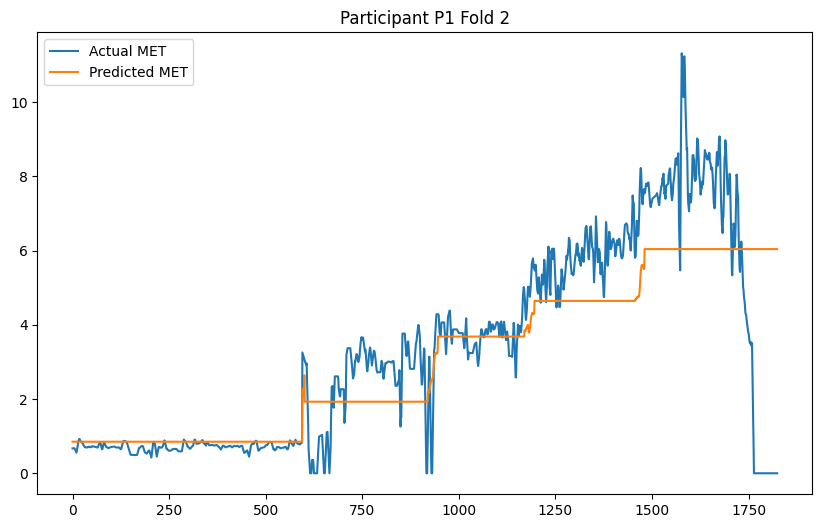

Learning rate set to 0.068435
0:	learn: 2.0779300	total: 5.9ms	remaining: 5.89s
1:	learn: 1.9770080	total: 11ms	remaining: 5.5s
2:	learn: 1.8851843	total: 15.8ms	remaining: 5.24s
3:	learn: 1.8015781	total: 20.1ms	remaining: 5s
4:	learn: 1.7258163	total: 24.7ms	remaining: 4.91s
5:	learn: 1.6570864	total: 29.1ms	remaining: 4.81s
6:	learn: 1.5948174	total: 34ms	remaining: 4.82s
7:	learn: 1.5385849	total: 38.7ms	remaining: 4.79s
8:	learn: 1.4882501	total: 43ms	remaining: 4.73s
9:	learn: 1.4430061	total: 47.3ms	remaining: 4.68s
10:	learn: 1.4028360	total: 52.2ms	remaining: 4.69s
11:	learn: 1.3666429	total: 56.6ms	remaining: 4.66s
12:	learn: 1.3343530	total: 61.4ms	remaining: 4.66s
13:	learn: 1.3060774	total: 65.7ms	remaining: 4.63s
14:	learn: 1.2806523	total: 70.4ms	remaining: 4.62s
15:	learn: 1.2583390	total: 74.9ms	remaining: 4.61s
16:	learn: 1.2383974	total: 79.3ms	remaining: 4.59s
17:	learn: 1.2207920	total: 83.9ms	remaining: 4.57s
18:	learn: 1.2053624	total: 89.1ms	remaining: 4.6s
19:	

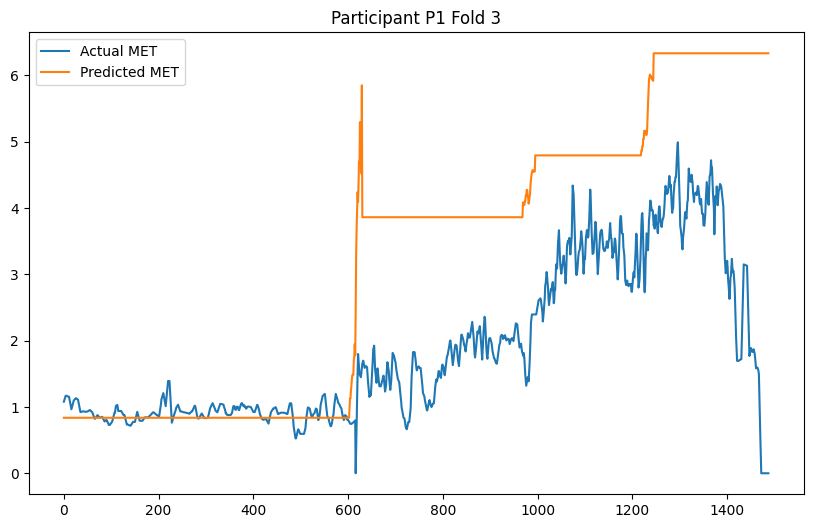

Learning rate set to 0.068299
0:	learn: 2.0855822	total: 5.4ms	remaining: 5.39s
1:	learn: 1.9902892	total: 9.72ms	remaining: 4.85s
2:	learn: 1.9039105	total: 14.5ms	remaining: 4.8s
3:	learn: 1.8260820	total: 19.2ms	remaining: 4.78s
4:	learn: 1.7551745	total: 25.5ms	remaining: 5.08s
5:	learn: 1.6911149	total: 29.8ms	remaining: 4.94s
6:	learn: 1.6332080	total: 34.5ms	remaining: 4.89s
7:	learn: 1.5811399	total: 42.8ms	remaining: 5.3s
8:	learn: 1.5346434	total: 48.9ms	remaining: 5.38s
9:	learn: 1.4929448	total: 53.2ms	remaining: 5.26s
10:	learn: 1.4558374	total: 57.8ms	remaining: 5.2s
11:	learn: 1.4227239	total: 64.1ms	remaining: 5.28s
12:	learn: 1.3933154	total: 68.7ms	remaining: 5.22s
13:	learn: 1.3676520	total: 73.1ms	remaining: 5.14s
14:	learn: 1.3445561	total: 78.1ms	remaining: 5.13s
15:	learn: 1.3244132	total: 82.5ms	remaining: 5.08s
16:	learn: 1.3063860	total: 87.2ms	remaining: 5.04s
17:	learn: 1.2905779	total: 91.8ms	remaining: 5.01s
18:	learn: 1.2766641	total: 96.2ms	remaining: 4.

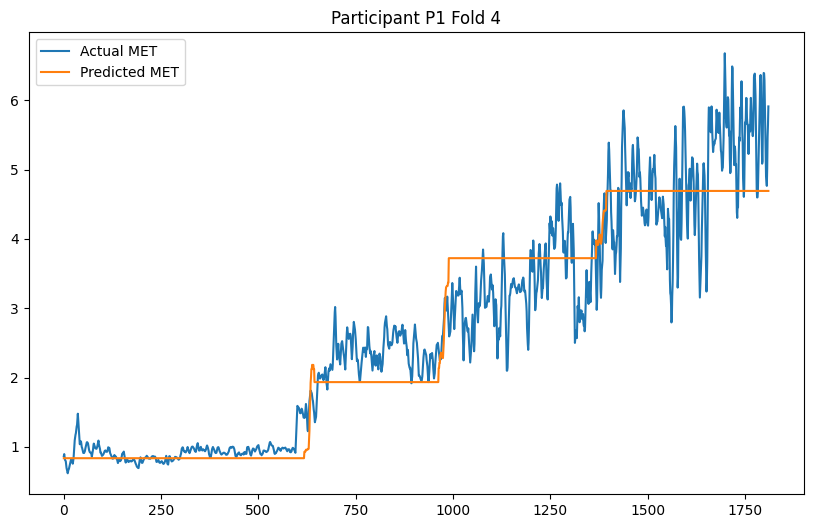

Learning rate set to 0.068341
0:	learn: 2.0467777	total: 5.7ms	remaining: 5.69s
1:	learn: 1.9543989	total: 10.5ms	remaining: 5.25s
2:	learn: 1.8707878	total: 15.6ms	remaining: 5.18s
3:	learn: 1.7954381	total: 20.8ms	remaining: 5.18s
4:	learn: 1.7265000	total: 25.2ms	remaining: 5.02s
5:	learn: 1.6645445	total: 30ms	remaining: 4.97s
6:	learn: 1.6086014	total: 34.5ms	remaining: 4.89s
7:	learn: 1.5583079	total: 40.3ms	remaining: 4.99s
8:	learn: 1.5136589	total: 49.4ms	remaining: 5.44s
9:	learn: 1.4750088	total: 53.3ms	remaining: 5.28s
10:	learn: 1.4391342	total: 58ms	remaining: 5.22s
11:	learn: 1.4070599	total: 62.7ms	remaining: 5.16s
12:	learn: 1.3786114	total: 67.4ms	remaining: 5.12s
13:	learn: 1.3533222	total: 71.8ms	remaining: 5.06s
14:	learn: 1.3311665	total: 76.3ms	remaining: 5.01s
15:	learn: 1.3114133	total: 80.9ms	remaining: 4.98s
16:	learn: 1.2942478	total: 85.9ms	remaining: 4.96s
17:	learn: 1.2791346	total: 90.7ms	remaining: 4.95s
18:	learn: 1.2655325	total: 95.2ms	remaining: 4.9

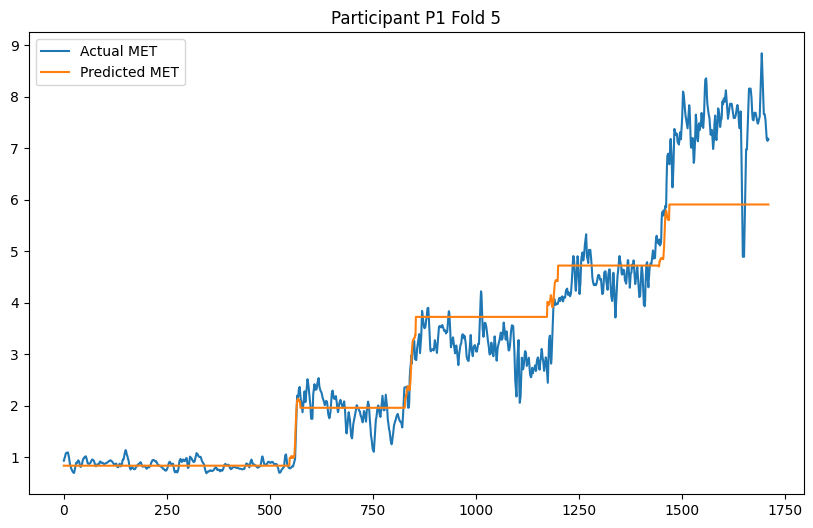

Learning rate set to 0.068371
0:	learn: 2.0658473	total: 5.89ms	remaining: 5.88s
1:	learn: 1.9674464	total: 10.9ms	remaining: 5.45s
2:	learn: 1.8782112	total: 15.9ms	remaining: 5.29s
3:	learn: 1.7974685	total: 20.9ms	remaining: 5.21s
4:	learn: 1.7238550	total: 25.5ms	remaining: 5.07s
5:	learn: 1.6570544	total: 29.9ms	remaining: 4.96s
6:	learn: 1.5967327	total: 34.8ms	remaining: 4.93s
7:	learn: 1.5423617	total: 39.6ms	remaining: 4.91s
8:	learn: 1.4939781	total: 44.6ms	remaining: 4.91s
9:	learn: 1.4502009	total: 49.6ms	remaining: 4.91s
10:	learn: 1.4110480	total: 54.6ms	remaining: 4.91s
11:	learn: 1.3761731	total: 59.4ms	remaining: 4.89s
12:	learn: 1.3451441	total: 64.4ms	remaining: 4.89s
13:	learn: 1.3179615	total: 68.7ms	remaining: 4.84s
14:	learn: 1.2934774	total: 73.7ms	remaining: 4.84s
15:	learn: 1.2717155	total: 78.4ms	remaining: 4.82s
16:	learn: 1.2525278	total: 89.4ms	remaining: 5.17s
17:	learn: 1.2356497	total: 93.9ms	remaining: 5.13s
18:	learn: 1.2212039	total: 98.6ms	remaining

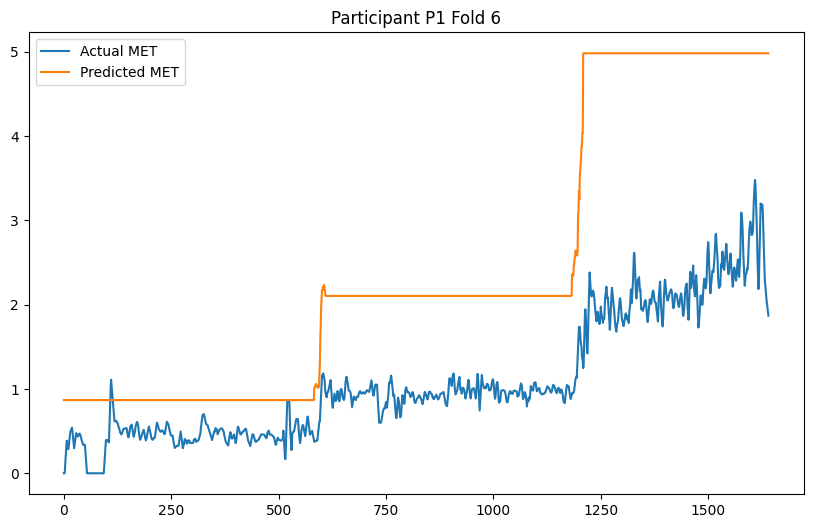

Learning rate set to 0.068309
0:	learn: 2.0834370	total: 5.54ms	remaining: 5.53s
1:	learn: 1.9873831	total: 10.3ms	remaining: 5.14s
2:	learn: 1.9003258	total: 15.2ms	remaining: 5.04s
3:	learn: 1.8212707	total: 19.8ms	remaining: 4.93s
4:	learn: 1.7497997	total: 25.4ms	remaining: 5.06s
5:	learn: 1.6851938	total: 29.8ms	remaining: 4.94s
6:	learn: 1.6267750	total: 38.5ms	remaining: 5.46s
7:	learn: 1.5741889	total: 53.6ms	remaining: 6.64s
8:	learn: 1.5275502	total: 61.9ms	remaining: 6.82s
9:	learn: 1.4854060	total: 69.4ms	remaining: 6.87s
10:	learn: 1.4478377	total: 83.1ms	remaining: 7.47s
11:	learn: 1.4143194	total: 91.1ms	remaining: 7.5s
12:	learn: 1.3845615	total: 101ms	remaining: 7.64s
13:	learn: 1.3585508	total: 111ms	remaining: 7.79s
14:	learn: 1.3351539	total: 120ms	remaining: 7.91s
15:	learn: 1.3147632	total: 136ms	remaining: 8.36s
16:	learn: 1.2965022	total: 145ms	remaining: 8.39s
17:	learn: 1.2804056	total: 151ms	remaining: 8.25s
18:	learn: 1.2662987	total: 160ms	remaining: 8.26s


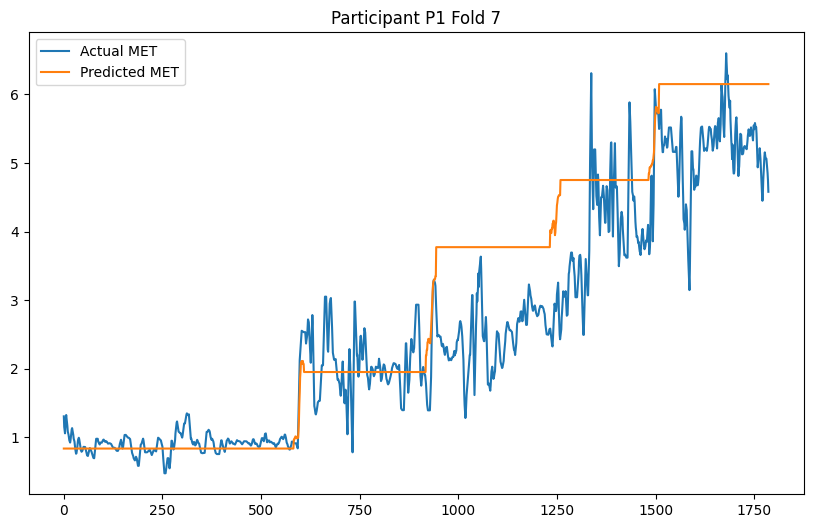

Learning rate set to 0.068346
0:	learn: 2.0724097	total: 5.67ms	remaining: 5.67s
1:	learn: 1.9753712	total: 10.2ms	remaining: 5.09s
2:	learn: 1.8874667	total: 15.7ms	remaining: 5.23s
3:	learn: 1.8080526	total: 20.4ms	remaining: 5.08s
4:	learn: 1.7356572	total: 25ms	remaining: 4.97s
5:	learn: 1.6701150	total: 29.5ms	remaining: 4.88s
6:	learn: 1.6108402	total: 34.1ms	remaining: 4.84s
7:	learn: 1.5574450	total: 38.8ms	remaining: 4.81s
8:	learn: 1.5100649	total: 43.6ms	remaining: 4.8s
9:	learn: 1.4672161	total: 48.2ms	remaining: 4.77s
10:	learn: 1.4290075	total: 53.1ms	remaining: 4.77s
11:	learn: 1.3948846	total: 57.8ms	remaining: 4.76s
12:	learn: 1.3645380	total: 62.9ms	remaining: 4.78s
13:	learn: 1.3380642	total: 69.3ms	remaining: 4.88s
14:	learn: 1.3141858	total: 74.8ms	remaining: 4.91s
15:	learn: 1.2933944	total: 79.8ms	remaining: 4.91s
16:	learn: 1.2747395	total: 84.7ms	remaining: 4.9s
17:	learn: 1.2583372	total: 89.4ms	remaining: 4.88s
18:	learn: 1.2439137	total: 94ms	remaining: 4.86

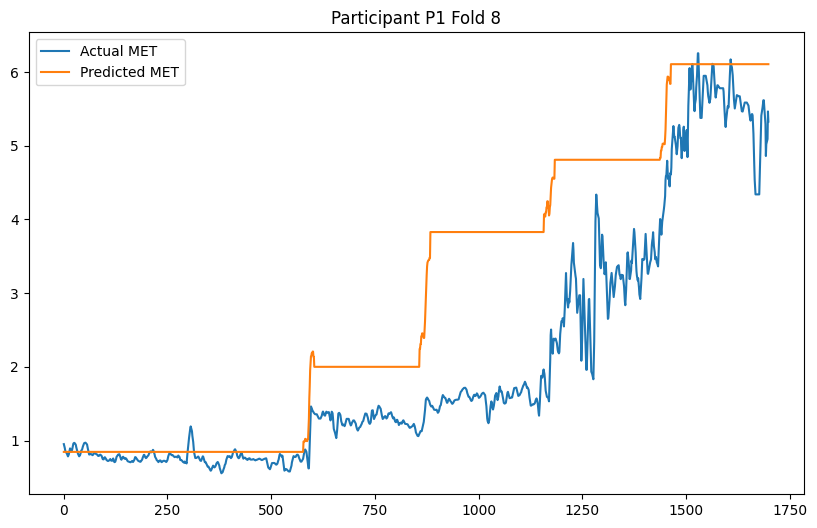

Learning rate set to 0.06841
0:	learn: 2.0479814	total: 14.7ms	remaining: 14.7s
1:	learn: 1.9542503	total: 22.9ms	remaining: 11.4s
2:	learn: 1.8692080	total: 36.1ms	remaining: 12s
3:	learn: 1.7926381	total: 45.1ms	remaining: 11.2s
4:	learn: 1.7228616	total: 56.9ms	remaining: 11.3s
5:	learn: 1.6597683	total: 69.1ms	remaining: 11.4s
6:	learn: 1.6028242	total: 82.1ms	remaining: 11.7s
7:	learn: 1.5515857	total: 95.4ms	remaining: 11.8s
8:	learn: 1.5061912	total: 108ms	remaining: 11.9s
9:	learn: 1.4651668	total: 121ms	remaining: 12s
10:	learn: 1.4286387	total: 136ms	remaining: 12.2s
11:	learn: 1.3960547	total: 152ms	remaining: 12.5s
12:	learn: 1.3671213	total: 165ms	remaining: 12.5s
13:	learn: 1.3418746	total: 178ms	remaining: 12.5s
14:	learn: 1.3191434	total: 190ms	remaining: 12.5s
15:	learn: 1.2994023	total: 202ms	remaining: 12.4s
16:	learn: 1.2816725	total: 217ms	remaining: 12.5s
17:	learn: 1.2660628	total: 231ms	remaining: 12.6s
18:	learn: 1.2523908	total: 245ms	remaining: 12.7s
19:	lear

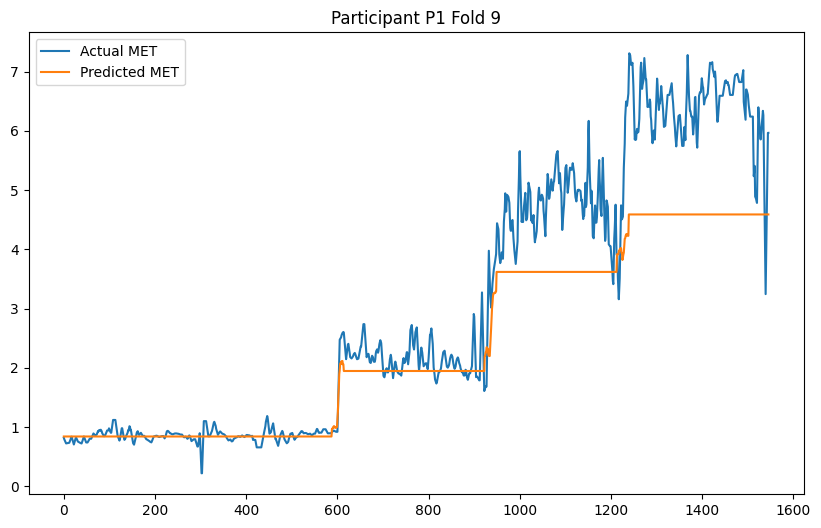

Learning rate set to 0.068492
0:	learn: 2.0877142	total: 5.35ms	remaining: 5.34s
1:	learn: 1.9908229	total: 10ms	remaining: 5.01s
2:	learn: 1.9031959	total: 14.8ms	remaining: 4.92s
3:	learn: 1.8234308	total: 19.1ms	remaining: 4.75s
4:	learn: 1.7513713	total: 23.6ms	remaining: 4.69s
5:	learn: 1.6863044	total: 31.9ms	remaining: 5.28s
6:	learn: 1.6274473	total: 39.4ms	remaining: 5.59s
7:	learn: 1.5744830	total: 52.6ms	remaining: 6.53s
8:	learn: 1.5274597	total: 60.7ms	remaining: 6.68s
9:	learn: 1.4850093	total: 65.1ms	remaining: 6.44s
10:	learn: 1.4472068	total: 70ms	remaining: 6.3s
11:	learn: 1.4137767	total: 75ms	remaining: 6.17s
12:	learn: 1.3837736	total: 80ms	remaining: 6.07s
13:	learn: 1.3575976	total: 84.4ms	remaining: 5.94s
14:	learn: 1.3340317	total: 89.2ms	remaining: 5.86s
15:	learn: 1.3132501	total: 93.7ms	remaining: 5.76s
16:	learn: 1.2948943	total: 98.2ms	remaining: 5.68s
17:	learn: 1.2787646	total: 103ms	remaining: 5.61s
18:	learn: 1.2645924	total: 107ms	remaining: 5.54s
19:

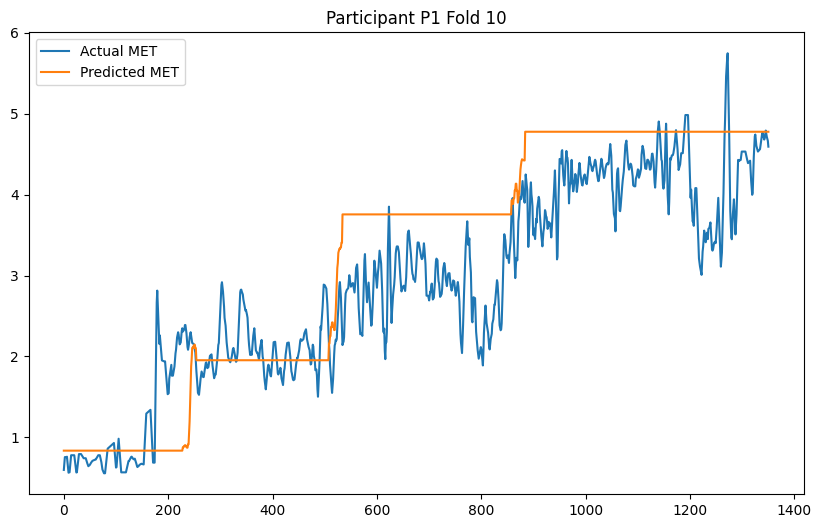

Learning rate set to 0.068322
0:	learn: 2.0762615	total: 5.83ms	remaining: 5.83s
1:	learn: 1.9814725	total: 10.9ms	remaining: 5.44s
2:	learn: 1.8954590	total: 15.8ms	remaining: 5.25s
3:	learn: 1.8179826	total: 20.6ms	remaining: 5.13s
4:	learn: 1.7473819	total: 25.2ms	remaining: 5.01s
5:	learn: 1.6836718	total: 29.7ms	remaining: 4.93s
6:	learn: 1.6260351	total: 34.4ms	remaining: 4.88s
7:	learn: 1.5741958	total: 39.3ms	remaining: 4.87s
8:	learn: 1.5279006	total: 44ms	remaining: 4.84s
9:	learn: 1.4863852	total: 48.6ms	remaining: 4.81s
10:	learn: 1.4497650	total: 53.7ms	remaining: 4.83s
11:	learn: 1.4167664	total: 58.5ms	remaining: 4.82s
12:	learn: 1.3874653	total: 63.7ms	remaining: 4.83s
13:	learn: 1.3618777	total: 68.2ms	remaining: 4.8s
14:	learn: 1.3388462	total: 73.3ms	remaining: 4.81s
15:	learn: 1.3185744	total: 78.1ms	remaining: 4.8s
16:	learn: 1.3006271	total: 83ms	remaining: 4.8s
17:	learn: 1.2848110	total: 87.8ms	remaining: 4.79s
18:	learn: 1.2709705	total: 92.5ms	remaining: 4.77s

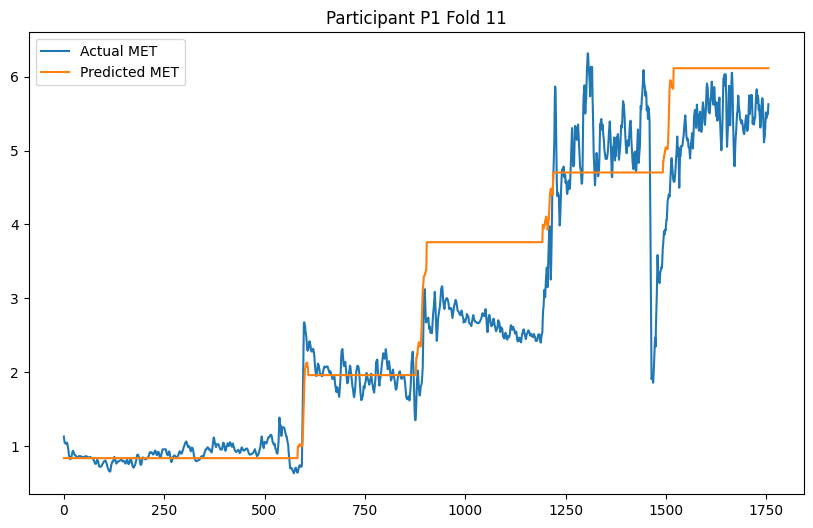

Learning rate set to 0.068344
0:	learn: 1.9649034	total: 5.17ms	remaining: 5.17s
1:	learn: 1.8721277	total: 9.92ms	remaining: 4.95s
2:	learn: 1.7880781	total: 14.7ms	remaining: 4.87s
3:	learn: 1.7114601	total: 19.4ms	remaining: 4.82s
4:	learn: 1.6419505	total: 24.3ms	remaining: 4.84s
5:	learn: 1.5791565	total: 35.7ms	remaining: 5.92s
6:	learn: 1.5224033	total: 40.4ms	remaining: 5.73s
7:	learn: 1.4713500	total: 47.6ms	remaining: 5.9s
8:	learn: 1.4254708	total: 52.4ms	remaining: 5.77s
9:	learn: 1.3843825	total: 57.3ms	remaining: 5.67s
10:	learn: 1.3476986	total: 61.9ms	remaining: 5.56s
11:	learn: 1.3149407	total: 66.6ms	remaining: 5.49s
12:	learn: 1.2858454	total: 71.2ms	remaining: 5.41s
13:	learn: 1.2600959	total: 75.3ms	remaining: 5.3s
14:	learn: 1.2371689	total: 80.3ms	remaining: 5.27s
15:	learn: 1.2169164	total: 84.8ms	remaining: 5.21s
16:	learn: 1.1990151	total: 89.6ms	remaining: 5.18s
17:	learn: 1.1832649	total: 93.9ms	remaining: 5.12s
18:	learn: 1.1694001	total: 98.5ms	remaining: 

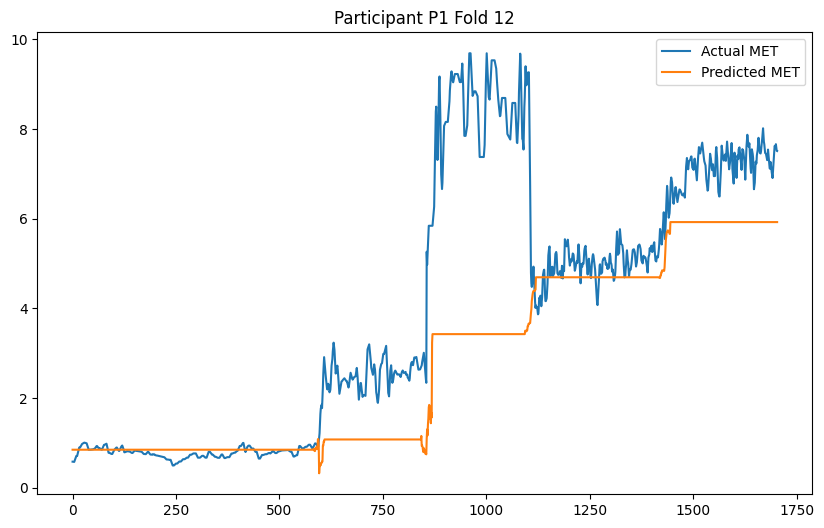

Learning rate set to 0.068306
0:	learn: 2.0788302	total: 5.34ms	remaining: 5.34s
1:	learn: 1.9843747	total: 9.99ms	remaining: 4.98s
2:	learn: 1.8988671	total: 14.5ms	remaining: 4.82s
3:	learn: 1.8212928	total: 18.8ms	remaining: 4.68s
4:	learn: 1.7511912	total: 23.1ms	remaining: 4.6s
5:	learn: 1.6878749	total: 27.3ms	remaining: 4.53s
6:	learn: 1.6306609	total: 31.8ms	remaining: 4.51s
7:	learn: 1.5791985	total: 36.5ms	remaining: 4.53s
8:	learn: 1.5335622	total: 41.2ms	remaining: 4.54s
9:	learn: 1.4923773	total: 45.6ms	remaining: 4.51s
10:	learn: 1.4560224	total: 50.4ms	remaining: 4.53s
11:	learn: 1.4232953	total: 54.6ms	remaining: 4.49s
12:	learn: 1.3942430	total: 59.1ms	remaining: 4.49s
13:	learn: 1.3689176	total: 63.5ms	remaining: 4.47s
14:	learn: 1.3461076	total: 68ms	remaining: 4.46s
15:	learn: 1.3262597	total: 72.3ms	remaining: 4.45s
16:	learn: 1.3084574	total: 76.7ms	remaining: 4.43s
17:	learn: 1.2927773	total: 80.8ms	remaining: 4.41s
18:	learn: 1.2790469	total: 84.9ms	remaining: 4

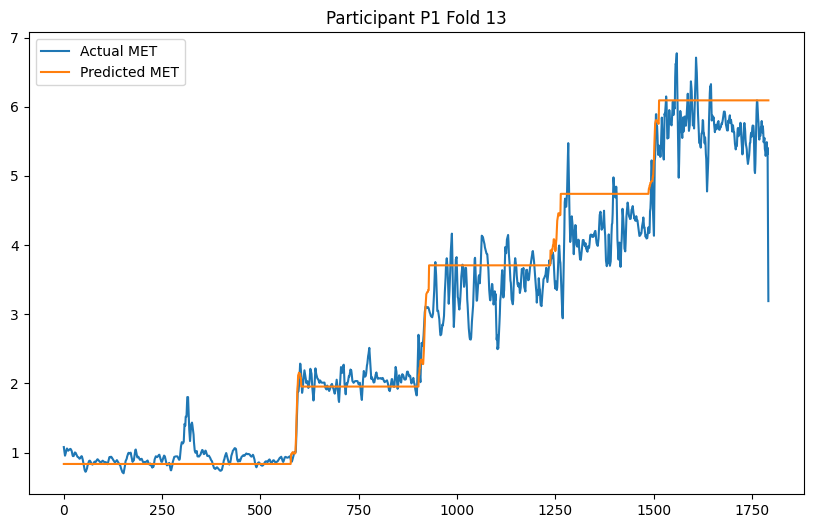

Learning rate set to 0.068691
0:	learn: 2.0678103	total: 5.16ms	remaining: 5.15s
1:	learn: 1.9725524	total: 9.86ms	remaining: 4.92s
2:	learn: 1.8862559	total: 14.5ms	remaining: 4.82s
3:	learn: 1.8085561	total: 19.5ms	remaining: 4.84s
4:	learn: 1.7377693	total: 23.9ms	remaining: 4.76s
5:	learn: 1.6738531	total: 28.2ms	remaining: 4.68s
6:	learn: 1.6161225	total: 32.6ms	remaining: 4.62s
7:	learn: 1.5642395	total: 39.8ms	remaining: 4.94s
8:	learn: 1.5183047	total: 45ms	remaining: 4.95s
9:	learn: 1.4767613	total: 49.6ms	remaining: 4.91s
10:	learn: 1.4401665	total: 55ms	remaining: 4.94s
11:	learn: 1.4075831	total: 60ms	remaining: 4.94s
12:	learn: 1.3782484	total: 64.8ms	remaining: 4.92s
13:	learn: 1.3527954	total: 69.1ms	remaining: 4.87s
14:	learn: 1.3297701	total: 74ms	remaining: 4.86s
15:	learn: 1.3095050	total: 83.5ms	remaining: 5.14s
16:	learn: 1.2915836	total: 89.2ms	remaining: 5.16s
17:	learn: 1.2758239	total: 95ms	remaining: 5.18s
18:	learn: 1.2620266	total: 109ms	remaining: 5.65s
19:

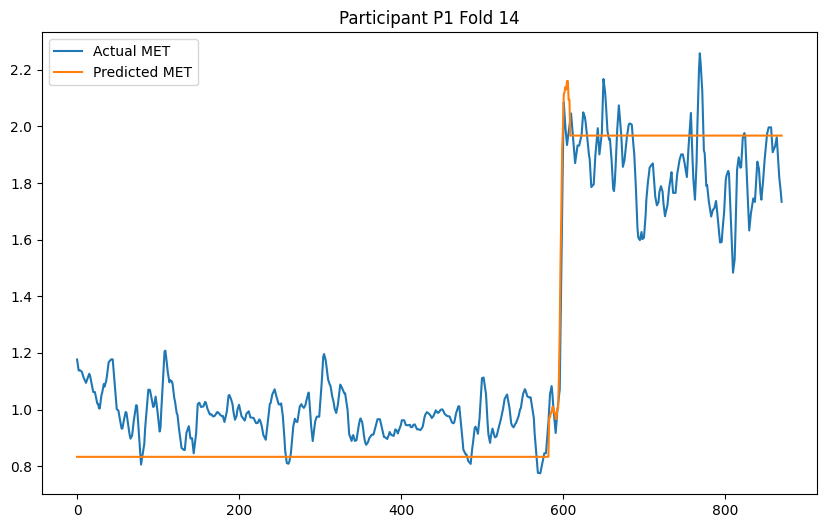

Learning rate set to 0.068408
0:	learn: 2.0203934	total: 5.5ms	remaining: 5.5s
1:	learn: 1.9272011	total: 10.6ms	remaining: 5.28s
2:	learn: 1.8426285	total: 15.5ms	remaining: 5.14s
3:	learn: 1.7664751	total: 20.5ms	remaining: 5.11s
4:	learn: 1.6970364	total: 25.2ms	remaining: 5.01s
5:	learn: 1.6343272	total: 29.7ms	remaining: 4.92s
6:	learn: 1.5775808	total: 34.2ms	remaining: 4.85s
7:	learn: 1.5265423	total: 39ms	remaining: 4.84s
8:	learn: 1.4813198	total: 44.1ms	remaining: 4.85s
9:	learn: 1.4403831	total: 48.4ms	remaining: 4.79s
10:	learn: 1.4043153	total: 57.9ms	remaining: 5.21s
11:	learn: 1.3716960	total: 64.1ms	remaining: 5.28s
12:	learn: 1.3427692	total: 70ms	remaining: 5.31s
13:	learn: 1.3175634	total: 74.2ms	remaining: 5.22s
14:	learn: 1.2948114	total: 79ms	remaining: 5.18s
15:	learn: 1.2750753	total: 89.6ms	remaining: 5.51s
16:	learn: 1.2572987	total: 97.3ms	remaining: 5.63s
17:	learn: 1.2416261	total: 108ms	remaining: 5.89s
18:	learn: 1.2279208	total: 112ms	remaining: 5.8s
19:

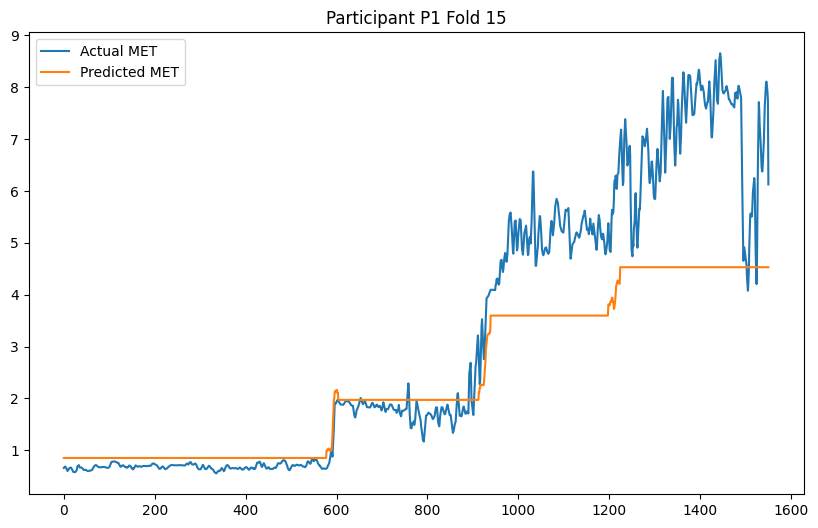

Learning rate set to 0.068558
0:	learn: 2.0535694	total: 6.76ms	remaining: 6.76s
1:	learn: 1.9579372	total: 13.9ms	remaining: 6.93s
2:	learn: 1.8710727	total: 20.6ms	remaining: 6.83s
3:	learn: 1.7922194	total: 26.6ms	remaining: 6.63s
4:	learn: 1.7208100	total: 33.2ms	remaining: 6.61s
5:	learn: 1.6562966	total: 39.3ms	remaining: 6.51s
6:	learn: 1.5979857	total: 45.4ms	remaining: 6.44s
7:	learn: 1.5456275	total: 57.8ms	remaining: 7.17s
8:	learn: 1.4990226	total: 74.5ms	remaining: 8.21s
9:	learn: 1.4569979	total: 91.6ms	remaining: 9.07s
10:	learn: 1.4198221	total: 106ms	remaining: 9.56s
11:	learn: 1.3863635	total: 120ms	remaining: 9.85s
12:	learn: 1.3566132	total: 133ms	remaining: 10.1s
13:	learn: 1.3307038	total: 147ms	remaining: 10.3s
14:	learn: 1.3078364	total: 158ms	remaining: 10.4s
15:	learn: 1.2874995	total: 175ms	remaining: 10.7s
16:	learn: 1.2692551	total: 189ms	remaining: 10.9s
17:	learn: 1.2531938	total: 207ms	remaining: 11.3s
18:	learn: 1.2391775	total: 215ms	remaining: 11.1s
1

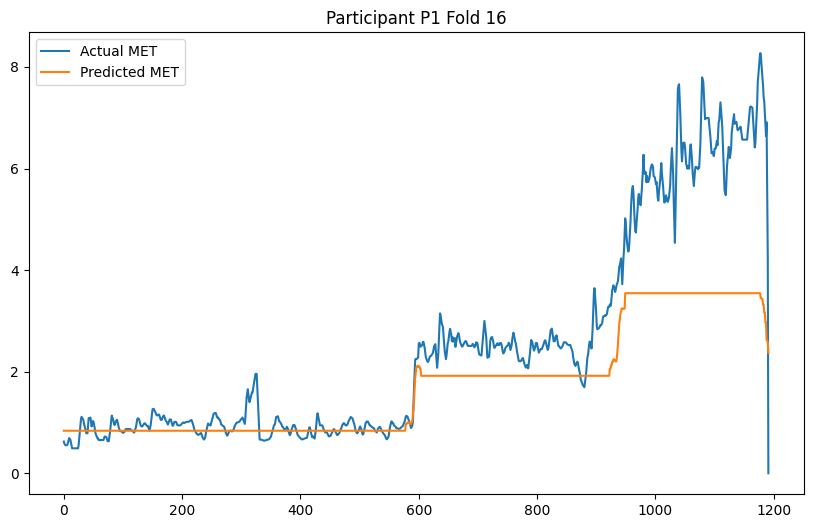

Learning rate set to 0.068307
0:	learn: 1.9622130	total: 5.64ms	remaining: 5.63s
1:	learn: 1.8727851	total: 10.4ms	remaining: 5.19s
2:	learn: 1.7919111	total: 15.1ms	remaining: 5.03s
3:	learn: 1.7189504	total: 19.7ms	remaining: 4.91s
4:	learn: 1.6523874	total: 23.9ms	remaining: 4.75s
5:	learn: 1.5923202	total: 28.3ms	remaining: 4.68s
6:	learn: 1.5380105	total: 32.7ms	remaining: 4.64s
7:	learn: 1.4891187	total: 37.3ms	remaining: 4.63s
8:	learn: 1.4457611	total: 41.8ms	remaining: 4.61s
9:	learn: 1.4083119	total: 45.4ms	remaining: 4.5s
10:	learn: 1.3732366	total: 49.8ms	remaining: 4.48s
11:	learn: 1.3420351	total: 54.3ms	remaining: 4.47s
12:	learn: 1.3145316	total: 58.9ms	remaining: 4.47s
13:	learn: 1.2897890	total: 64.2ms	remaining: 4.52s
14:	learn: 1.2681089	total: 68.6ms	remaining: 4.5s
15:	learn: 1.2490980	total: 73.3ms	remaining: 4.51s
16:	learn: 1.2323330	total: 78ms	remaining: 4.51s
17:	learn: 1.2173369	total: 82.3ms	remaining: 4.49s
18:	learn: 1.2040765	total: 87ms	remaining: 4.49

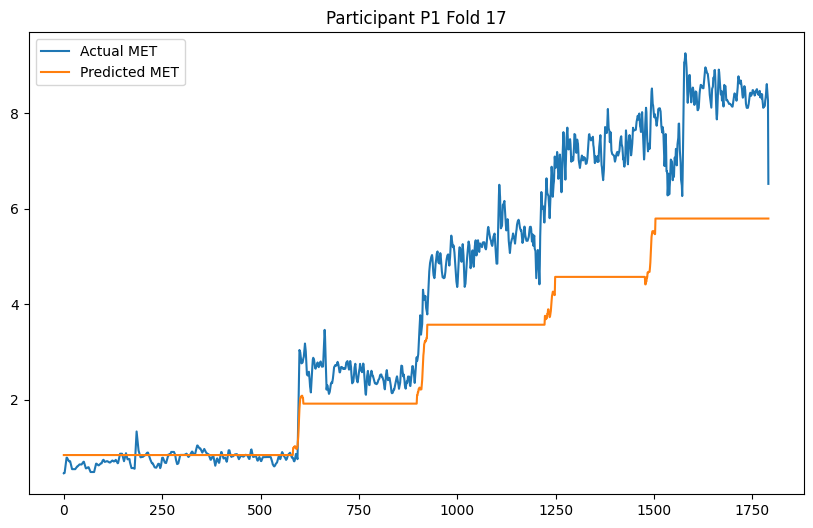

In [111]:
import matplotlib.pyplot as plt
# Import MAE
from sklearn.metrics import mean_absolute_error
# Plot the actual MET and the predicted MET for participants
# print(X_data, Y_data, participants)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    # print(train_index, test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant {0} Fold {1}'.format(people[fold], fold+1))
    plt.legend()
    plt.show()

Learning rate set to 0.068306
0:	learn: 2.0694450	total: 16.2ms	remaining: 16.2s
1:	learn: 1.9755260	total: 23.9ms	remaining: 11.9s
2:	learn: 1.8903655	total: 31.2ms	remaining: 10.4s
3:	learn: 1.8137527	total: 37.4ms	remaining: 9.3s
4:	learn: 1.7436408	total: 43.2ms	remaining: 8.59s
5:	learn: 1.6806203	total: 49.2ms	remaining: 8.14s
6:	learn: 1.6236047	total: 54.8ms	remaining: 7.77s
7:	learn: 1.5723606	total: 60.8ms	remaining: 7.54s
8:	learn: 1.5268478	total: 66.7ms	remaining: 7.35s
9:	learn: 1.4857852	total: 72.6ms	remaining: 7.19s
10:	learn: 1.4492983	total: 79.1ms	remaining: 7.11s
11:	learn: 1.4167119	total: 85.5ms	remaining: 7.04s
12:	learn: 1.3877807	total: 92.1ms	remaining: 6.99s
13:	learn: 1.3625335	total: 98.1ms	remaining: 6.91s
14:	learn: 1.3398253	total: 111ms	remaining: 7.27s
15:	learn: 1.3200716	total: 121ms	remaining: 7.45s
16:	learn: 1.3023314	total: 133ms	remaining: 7.7s
17:	learn: 1.2867141	total: 141ms	remaining: 7.68s
18:	learn: 1.2730314	total: 154ms	remaining: 7.95s

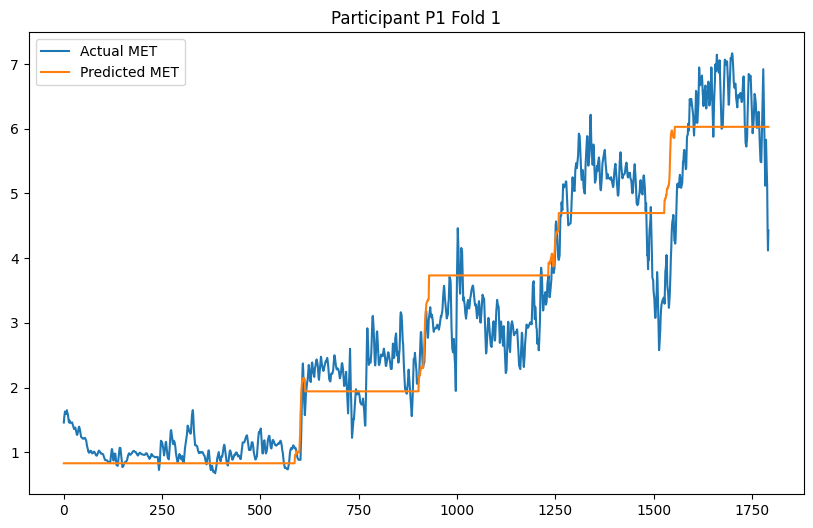

Learning rate set to 0.068293
0:	learn: 2.0055742	total: 5.5ms	remaining: 5.49s
1:	learn: 1.9120783	total: 10.2ms	remaining: 5.09s
2:	learn: 1.8273161	total: 15.6ms	remaining: 5.17s
3:	learn: 1.7503036	total: 20.3ms	remaining: 5.06s
4:	learn: 1.6806769	total: 24.8ms	remaining: 4.92s
5:	learn: 1.6176825	total: 29.4ms	remaining: 4.87s
6:	learn: 1.5607024	total: 34.4ms	remaining: 4.88s
7:	learn: 1.5093379	total: 39.4ms	remaining: 4.89s
8:	learn: 1.4637585	total: 44.3ms	remaining: 4.87s
9:	learn: 1.4225362	total: 48.7ms	remaining: 4.82s
10:	learn: 1.3857809	total: 53.5ms	remaining: 4.81s
11:	learn: 1.3529053	total: 58.2ms	remaining: 4.79s
12:	learn: 1.3237632	total: 63.1ms	remaining: 4.79s
13:	learn: 1.2982719	total: 67.5ms	remaining: 4.75s
14:	learn: 1.2753237	total: 72.3ms	remaining: 4.75s
15:	learn: 1.2553869	total: 77.2ms	remaining: 4.75s
16:	learn: 1.2374798	total: 81.9ms	remaining: 4.74s
17:	learn: 1.2217277	total: 86.6ms	remaining: 4.72s
18:	learn: 1.2079150	total: 91.4ms	remaining:

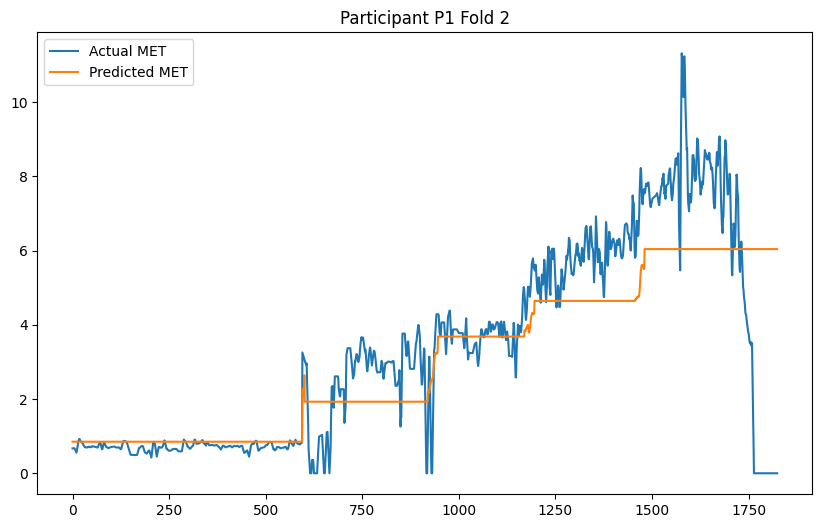

Learning rate set to 0.068435
0:	learn: 2.0779300	total: 5.38ms	remaining: 5.37s
1:	learn: 1.9770080	total: 10.3ms	remaining: 5.14s
2:	learn: 1.8851843	total: 15.3ms	remaining: 5.07s
3:	learn: 1.8015781	total: 19.6ms	remaining: 4.89s
4:	learn: 1.7258163	total: 24.1ms	remaining: 4.79s
5:	learn: 1.6570864	total: 28.4ms	remaining: 4.71s
6:	learn: 1.5948174	total: 38.2ms	remaining: 5.41s
7:	learn: 1.5385849	total: 42.9ms	remaining: 5.32s
8:	learn: 1.4882501	total: 47.5ms	remaining: 5.22s
9:	learn: 1.4430061	total: 52.1ms	remaining: 5.16s
10:	learn: 1.4028360	total: 57.1ms	remaining: 5.14s
11:	learn: 1.3666429	total: 61.6ms	remaining: 5.07s
12:	learn: 1.3343530	total: 66.6ms	remaining: 5.05s
13:	learn: 1.3060774	total: 72.7ms	remaining: 5.12s
14:	learn: 1.2806523	total: 78ms	remaining: 5.12s
15:	learn: 1.2583390	total: 82.5ms	remaining: 5.07s
16:	learn: 1.2383974	total: 86.9ms	remaining: 5.02s
17:	learn: 1.2207920	total: 92.8ms	remaining: 5.06s
18:	learn: 1.2053624	total: 97.3ms	remaining: 

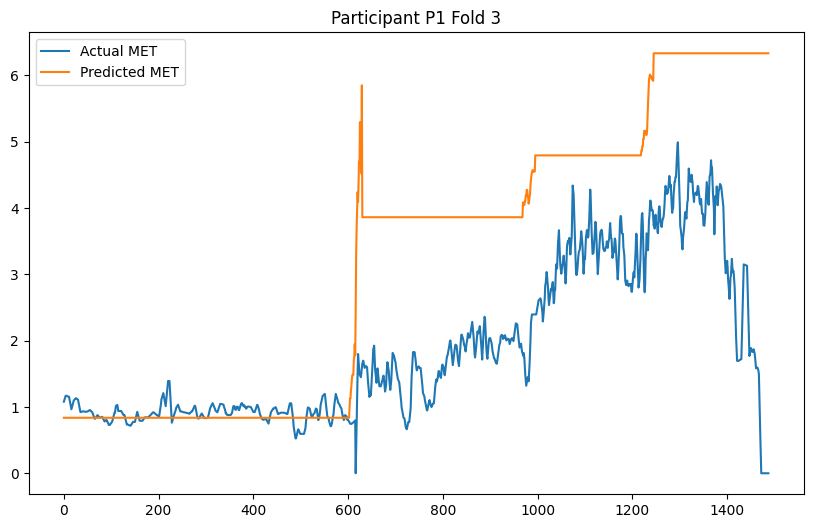

Learning rate set to 0.068299
0:	learn: 2.0855822	total: 5.28ms	remaining: 5.27s
1:	learn: 1.9902892	total: 10.1ms	remaining: 5.05s
2:	learn: 1.9039105	total: 15.2ms	remaining: 5.05s
3:	learn: 1.8260820	total: 20ms	remaining: 4.98s
4:	learn: 1.7551745	total: 24.9ms	remaining: 4.95s
5:	learn: 1.6911149	total: 29.6ms	remaining: 4.91s
6:	learn: 1.6332080	total: 34.6ms	remaining: 4.9s
7:	learn: 1.5811399	total: 39.3ms	remaining: 4.87s
8:	learn: 1.5346434	total: 44.1ms	remaining: 4.85s
9:	learn: 1.4929448	total: 48.7ms	remaining: 4.83s
10:	learn: 1.4558374	total: 59.5ms	remaining: 5.34s
11:	learn: 1.4227239	total: 68.4ms	remaining: 5.63s
12:	learn: 1.3933154	total: 75.9ms	remaining: 5.76s
13:	learn: 1.3676520	total: 80.2ms	remaining: 5.65s
14:	learn: 1.3445561	total: 85.5ms	remaining: 5.61s
15:	learn: 1.3244132	total: 91.8ms	remaining: 5.64s
16:	learn: 1.3063860	total: 96.7ms	remaining: 5.59s
17:	learn: 1.2905779	total: 101ms	remaining: 5.52s
18:	learn: 1.2766641	total: 106ms	remaining: 5.4

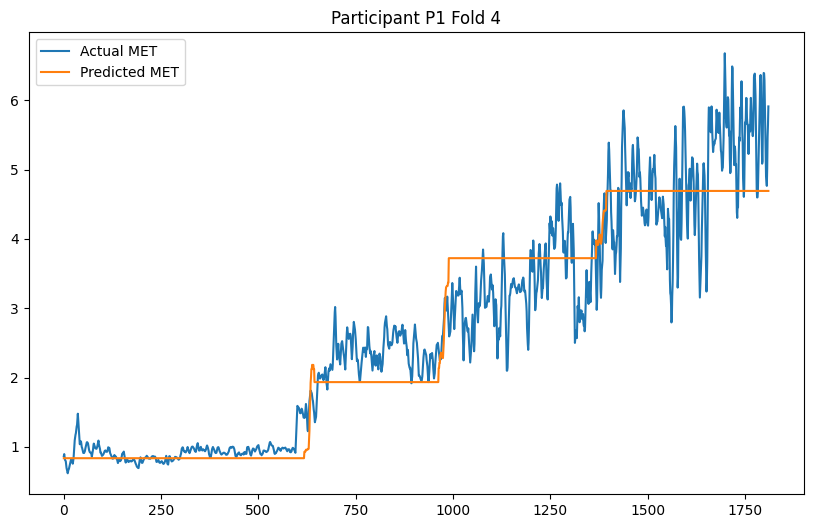

Learning rate set to 0.068341
0:	learn: 2.0467777	total: 8.43ms	remaining: 8.42s
1:	learn: 1.9543989	total: 13.6ms	remaining: 6.79s
2:	learn: 1.8707878	total: 18.6ms	remaining: 6.19s
3:	learn: 1.7954381	total: 23.6ms	remaining: 5.87s
4:	learn: 1.7265000	total: 28.3ms	remaining: 5.62s
5:	learn: 1.6645445	total: 32.9ms	remaining: 5.46s
6:	learn: 1.6086014	total: 37.6ms	remaining: 5.33s
7:	learn: 1.5583079	total: 42.6ms	remaining: 5.28s
8:	learn: 1.5136589	total: 47.6ms	remaining: 5.24s
9:	learn: 1.4750088	total: 51.6ms	remaining: 5.11s
10:	learn: 1.4391342	total: 56.2ms	remaining: 5.05s
11:	learn: 1.4070599	total: 60.9ms	remaining: 5.01s
12:	learn: 1.3786114	total: 65.8ms	remaining: 4.99s
13:	learn: 1.3533222	total: 70.5ms	remaining: 4.96s
14:	learn: 1.3311665	total: 74.8ms	remaining: 4.91s
15:	learn: 1.3114133	total: 79.2ms	remaining: 4.87s
16:	learn: 1.2942478	total: 83.9ms	remaining: 4.85s
17:	learn: 1.2791346	total: 88.7ms	remaining: 4.84s
18:	learn: 1.2655325	total: 93.4ms	remaining

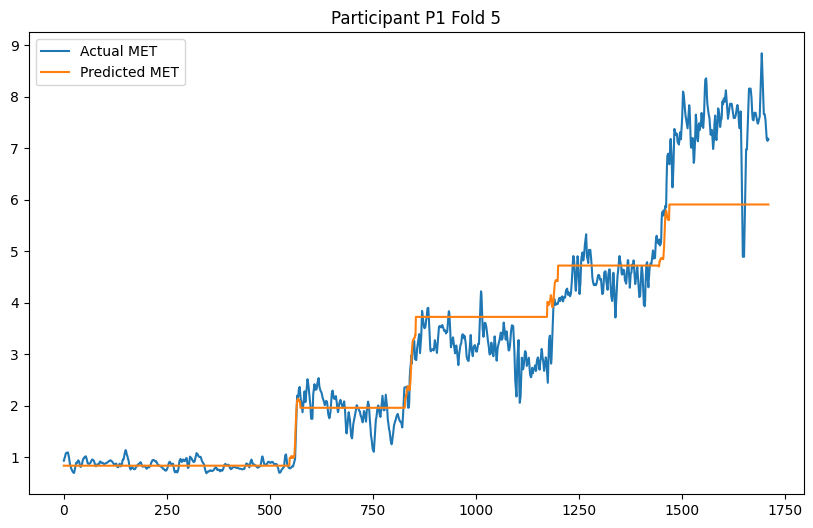

Learning rate set to 0.068371
0:	learn: 2.0658473	total: 5.57ms	remaining: 5.57s
1:	learn: 1.9674464	total: 10.4ms	remaining: 5.17s
2:	learn: 1.8782112	total: 15.4ms	remaining: 5.12s
3:	learn: 1.7974685	total: 22.6ms	remaining: 5.63s
4:	learn: 1.7238550	total: 27ms	remaining: 5.38s
5:	learn: 1.6570544	total: 31.3ms	remaining: 5.18s
6:	learn: 1.5967327	total: 36.1ms	remaining: 5.12s
7:	learn: 1.5423617	total: 40.7ms	remaining: 5.05s
8:	learn: 1.4939781	total: 45.8ms	remaining: 5.04s
9:	learn: 1.4502009	total: 50.7ms	remaining: 5.02s
10:	learn: 1.4110480	total: 55.4ms	remaining: 4.98s
11:	learn: 1.3761731	total: 59.9ms	remaining: 4.93s
12:	learn: 1.3451441	total: 64.6ms	remaining: 4.9s
13:	learn: 1.3179615	total: 68.7ms	remaining: 4.84s
14:	learn: 1.2934774	total: 73.4ms	remaining: 4.82s
15:	learn: 1.2717155	total: 77.9ms	remaining: 4.79s
16:	learn: 1.2525278	total: 82.8ms	remaining: 4.79s
17:	learn: 1.2356497	total: 87.4ms	remaining: 4.77s
18:	learn: 1.2212039	total: 91.9ms	remaining: 4

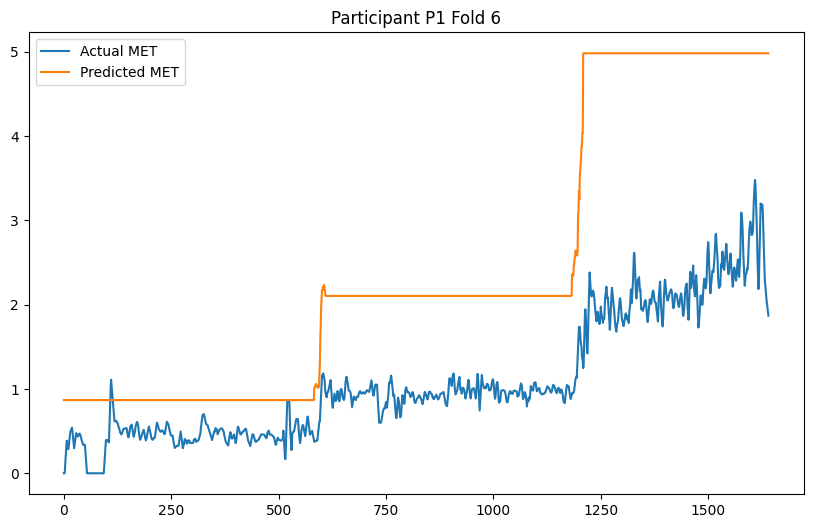

Learning rate set to 0.068309
0:	learn: 2.0834370	total: 7.85ms	remaining: 7.84s
1:	learn: 1.9873831	total: 12.3ms	remaining: 6.14s
2:	learn: 1.9003258	total: 17.4ms	remaining: 5.78s
3:	learn: 1.8212707	total: 21.9ms	remaining: 5.45s
4:	learn: 1.7497997	total: 26.6ms	remaining: 5.3s
5:	learn: 1.6851938	total: 33.8ms	remaining: 5.59s
6:	learn: 1.6267750	total: 41.4ms	remaining: 5.87s
7:	learn: 1.5741889	total: 46.1ms	remaining: 5.72s
8:	learn: 1.5275502	total: 51ms	remaining: 5.61s
9:	learn: 1.4854060	total: 55.3ms	remaining: 5.47s
10:	learn: 1.4478377	total: 60.5ms	remaining: 5.44s
11:	learn: 1.4143194	total: 65.1ms	remaining: 5.36s
12:	learn: 1.3845615	total: 70.2ms	remaining: 5.33s
13:	learn: 1.3585508	total: 74.8ms	remaining: 5.26s
14:	learn: 1.3351539	total: 79.8ms	remaining: 5.24s
15:	learn: 1.3147632	total: 84.6ms	remaining: 5.21s
16:	learn: 1.2965022	total: 89.4ms	remaining: 5.17s
17:	learn: 1.2804056	total: 94ms	remaining: 5.13s
18:	learn: 1.2662987	total: 98.5ms	remaining: 5.0

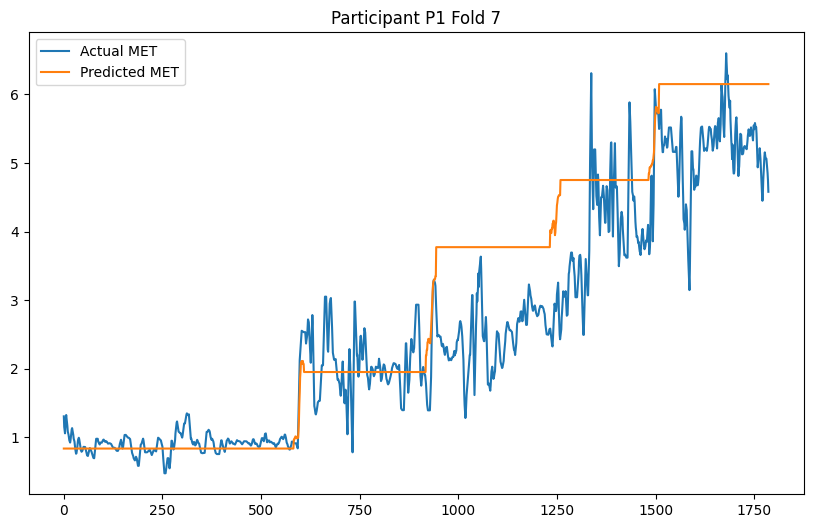

Learning rate set to 0.068346
0:	learn: 2.0724097	total: 14.2ms	remaining: 14.1s
1:	learn: 1.9753712	total: 21.9ms	remaining: 11s
2:	learn: 1.8874667	total: 34.3ms	remaining: 11.4s
3:	learn: 1.8080526	total: 44.7ms	remaining: 11.1s
4:	learn: 1.7356572	total: 59ms	remaining: 11.7s
5:	learn: 1.6701150	total: 71.8ms	remaining: 11.9s
6:	learn: 1.6108402	total: 84.6ms	remaining: 12s
7:	learn: 1.5574450	total: 99.6ms	remaining: 12.4s
8:	learn: 1.5100649	total: 114ms	remaining: 12.6s
9:	learn: 1.4672161	total: 125ms	remaining: 12.3s
10:	learn: 1.4290075	total: 140ms	remaining: 12.6s
11:	learn: 1.3948846	total: 165ms	remaining: 13.6s
12:	learn: 1.3645380	total: 176ms	remaining: 13.4s
13:	learn: 1.3380642	total: 183ms	remaining: 12.9s
14:	learn: 1.3141858	total: 192ms	remaining: 12.6s
15:	learn: 1.2933944	total: 205ms	remaining: 12.6s
16:	learn: 1.2747395	total: 216ms	remaining: 12.5s
17:	learn: 1.2583372	total: 230ms	remaining: 12.6s
18:	learn: 1.2439137	total: 243ms	remaining: 12.6s
19:	learn

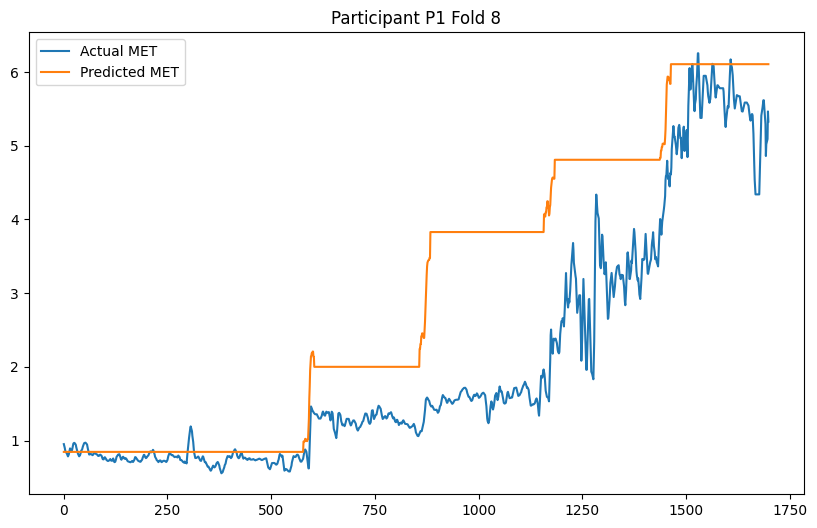

Learning rate set to 0.06841
0:	learn: 2.0479814	total: 6.3ms	remaining: 6.3s
1:	learn: 1.9542503	total: 11.2ms	remaining: 5.58s
2:	learn: 1.8692080	total: 16.4ms	remaining: 5.46s
3:	learn: 1.7926381	total: 21.3ms	remaining: 5.31s
4:	learn: 1.7228616	total: 25.8ms	remaining: 5.13s
5:	learn: 1.6597683	total: 30.3ms	remaining: 5.01s
6:	learn: 1.6028242	total: 35.6ms	remaining: 5.05s
7:	learn: 1.5515857	total: 40.3ms	remaining: 4.99s
8:	learn: 1.5061912	total: 45ms	remaining: 4.95s
9:	learn: 1.4651668	total: 49.3ms	remaining: 4.88s
10:	learn: 1.4286387	total: 54ms	remaining: 4.86s
11:	learn: 1.3960547	total: 58.4ms	remaining: 4.81s
12:	learn: 1.3671213	total: 63.1ms	remaining: 4.79s
13:	learn: 1.3418746	total: 67.4ms	remaining: 4.75s
14:	learn: 1.3191434	total: 72.2ms	remaining: 4.74s
15:	learn: 1.2994023	total: 76.9ms	remaining: 4.73s
16:	learn: 1.2816725	total: 81.9ms	remaining: 4.73s
17:	learn: 1.2660628	total: 86.2ms	remaining: 4.7s
18:	learn: 1.2523908	total: 90.5ms	remaining: 4.67s


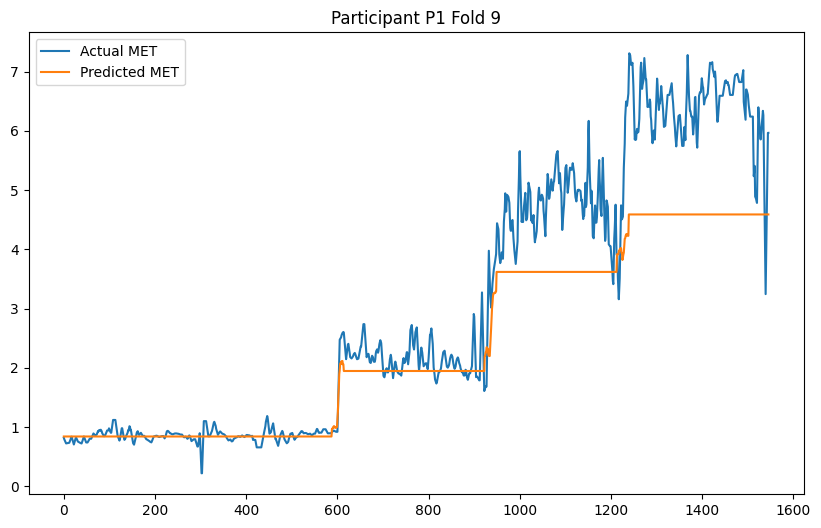

Learning rate set to 0.068492
0:	learn: 2.0877142	total: 5.44ms	remaining: 5.44s
1:	learn: 1.9908229	total: 10.1ms	remaining: 5.03s
2:	learn: 1.9031959	total: 14.9ms	remaining: 4.95s
3:	learn: 1.8234308	total: 19.3ms	remaining: 4.8s
4:	learn: 1.7513713	total: 23.8ms	remaining: 4.73s
5:	learn: 1.6863044	total: 28.2ms	remaining: 4.68s
6:	learn: 1.6274473	total: 33.3ms	remaining: 4.72s
7:	learn: 1.5744830	total: 38.4ms	remaining: 4.76s
8:	learn: 1.5274597	total: 43.2ms	remaining: 4.76s
9:	learn: 1.4850093	total: 47.6ms	remaining: 4.71s
10:	learn: 1.4472068	total: 52.4ms	remaining: 4.71s
11:	learn: 1.4137767	total: 57.8ms	remaining: 4.76s
12:	learn: 1.3837736	total: 62.8ms	remaining: 4.77s
13:	learn: 1.3575976	total: 66.9ms	remaining: 4.71s
14:	learn: 1.3340317	total: 71.7ms	remaining: 4.71s
15:	learn: 1.3132501	total: 77.3ms	remaining: 4.75s
16:	learn: 1.2948943	total: 81.7ms	remaining: 4.72s
17:	learn: 1.2787646	total: 86ms	remaining: 4.69s
18:	learn: 1.2645924	total: 90.4ms	remaining: 4

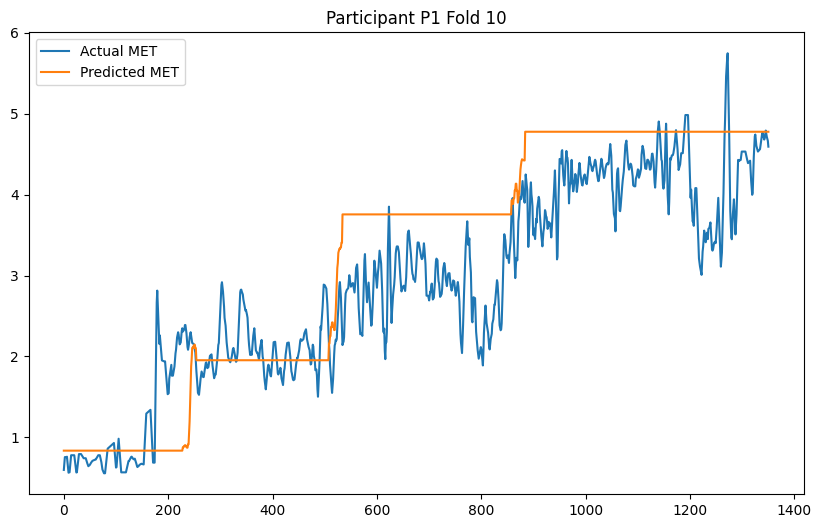

Learning rate set to 0.068322
0:	learn: 2.0762615	total: 5.26ms	remaining: 5.26s
1:	learn: 1.9814725	total: 10ms	remaining: 4.99s
2:	learn: 1.8954590	total: 15.5ms	remaining: 5.15s
3:	learn: 1.8179826	total: 20.1ms	remaining: 5.01s
4:	learn: 1.7473819	total: 24.5ms	remaining: 4.88s
5:	learn: 1.6836718	total: 28.8ms	remaining: 4.77s
6:	learn: 1.6260351	total: 33ms	remaining: 4.68s
7:	learn: 1.5741958	total: 37.6ms	remaining: 4.67s
8:	learn: 1.5279006	total: 41.9ms	remaining: 4.61s
9:	learn: 1.4863852	total: 46.4ms	remaining: 4.59s
10:	learn: 1.4497650	total: 51.1ms	remaining: 4.59s
11:	learn: 1.4167664	total: 56.5ms	remaining: 4.66s
12:	learn: 1.3874653	total: 74.6ms	remaining: 5.66s
13:	learn: 1.3618777	total: 83.6ms	remaining: 5.89s
14:	learn: 1.3388462	total: 91.4ms	remaining: 6s
15:	learn: 1.3185744	total: 96ms	remaining: 5.9s
16:	learn: 1.3006271	total: 101ms	remaining: 5.83s
17:	learn: 1.2848110	total: 105ms	remaining: 5.75s
18:	learn: 1.2709705	total: 110ms	remaining: 5.66s
19:	l

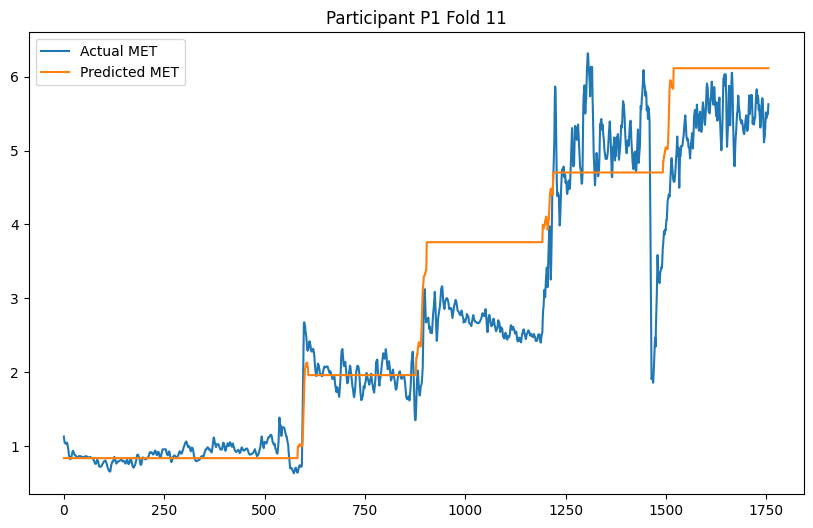

Learning rate set to 0.068344
0:	learn: 1.9649034	total: 5.3ms	remaining: 5.3s
1:	learn: 1.8721277	total: 10.2ms	remaining: 5.1s
2:	learn: 1.7880781	total: 15.2ms	remaining: 5.05s
3:	learn: 1.7114601	total: 19.8ms	remaining: 4.92s
4:	learn: 1.6419505	total: 24.5ms	remaining: 4.88s
5:	learn: 1.5791565	total: 29.1ms	remaining: 4.81s
6:	learn: 1.5224033	total: 33.6ms	remaining: 4.77s
7:	learn: 1.4713500	total: 38.4ms	remaining: 4.76s
8:	learn: 1.4254708	total: 43.7ms	remaining: 4.81s
9:	learn: 1.3843825	total: 48.7ms	remaining: 4.82s
10:	learn: 1.3476986	total: 53.8ms	remaining: 4.84s
11:	learn: 1.3149407	total: 58.8ms	remaining: 4.84s
12:	learn: 1.2858454	total: 63.7ms	remaining: 4.83s
13:	learn: 1.2600959	total: 68ms	remaining: 4.79s
14:	learn: 1.2371689	total: 72.7ms	remaining: 4.77s
15:	learn: 1.2169164	total: 77.2ms	remaining: 4.75s
16:	learn: 1.1990151	total: 81.7ms	remaining: 4.73s
17:	learn: 1.1832649	total: 86.1ms	remaining: 4.7s
18:	learn: 1.1694001	total: 91.2ms	remaining: 4.71

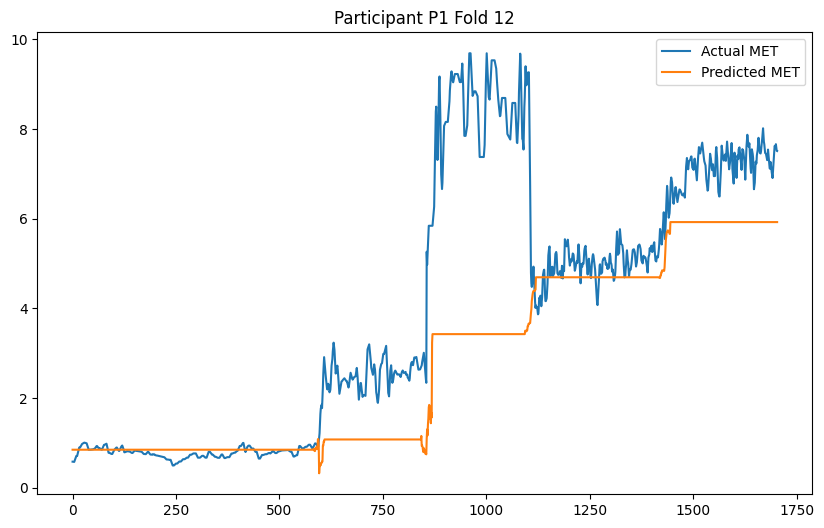

Learning rate set to 0.068306
0:	learn: 2.0788302	total: 6.79ms	remaining: 6.79s
1:	learn: 1.9843747	total: 11.3ms	remaining: 5.62s
2:	learn: 1.8988671	total: 16.5ms	remaining: 5.5s
3:	learn: 1.8212928	total: 22.1ms	remaining: 5.51s
4:	learn: 1.7511912	total: 26.7ms	remaining: 5.31s
5:	learn: 1.6878749	total: 31.3ms	remaining: 5.18s
6:	learn: 1.6306609	total: 36.1ms	remaining: 5.12s
7:	learn: 1.5791985	total: 40.9ms	remaining: 5.08s
8:	learn: 1.5335622	total: 45.9ms	remaining: 5.05s
9:	learn: 1.4923773	total: 50.4ms	remaining: 4.99s
10:	learn: 1.4560224	total: 55.3ms	remaining: 4.97s
11:	learn: 1.4232953	total: 59.9ms	remaining: 4.93s
12:	learn: 1.3942430	total: 64.9ms	remaining: 4.92s
13:	learn: 1.3689176	total: 69.3ms	remaining: 4.88s
14:	learn: 1.3461076	total: 74.2ms	remaining: 4.87s
15:	learn: 1.3262597	total: 79.1ms	remaining: 4.86s
16:	learn: 1.3084574	total: 83.6ms	remaining: 4.84s
17:	learn: 1.2927773	total: 88.2ms	remaining: 4.81s
18:	learn: 1.2790469	total: 92.8ms	remaining:

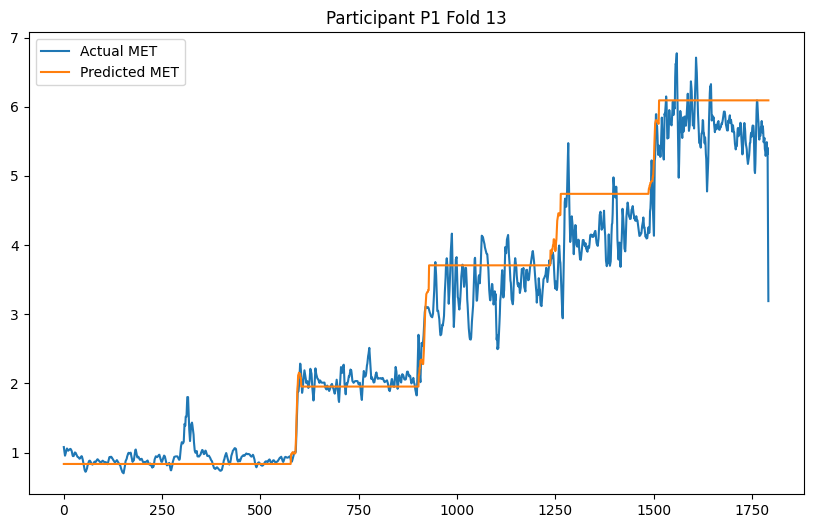

Learning rate set to 0.068691
0:	learn: 2.0678103	total: 5.42ms	remaining: 5.41s
1:	learn: 1.9725524	total: 9.59ms	remaining: 4.79s
2:	learn: 1.8862559	total: 14.4ms	remaining: 4.79s
3:	learn: 1.8085561	total: 19.1ms	remaining: 4.76s
4:	learn: 1.7377693	total: 23.5ms	remaining: 4.67s
5:	learn: 1.6738531	total: 28.1ms	remaining: 4.65s
6:	learn: 1.6161225	total: 32.6ms	remaining: 4.63s
7:	learn: 1.5642395	total: 37.2ms	remaining: 4.62s
8:	learn: 1.5183047	total: 43.9ms	remaining: 4.84s
9:	learn: 1.4767613	total: 49.9ms	remaining: 4.93s
10:	learn: 1.4401665	total: 54.9ms	remaining: 4.93s
11:	learn: 1.4075831	total: 59.7ms	remaining: 4.91s
12:	learn: 1.3782484	total: 64.5ms	remaining: 4.9s
13:	learn: 1.3527954	total: 68.8ms	remaining: 4.84s
14:	learn: 1.3297701	total: 75.1ms	remaining: 4.93s
15:	learn: 1.3095050	total: 79.9ms	remaining: 4.91s
16:	learn: 1.2915836	total: 84.6ms	remaining: 4.89s
17:	learn: 1.2758239	total: 89.9ms	remaining: 4.9s
18:	learn: 1.2620266	total: 94.4ms	remaining: 

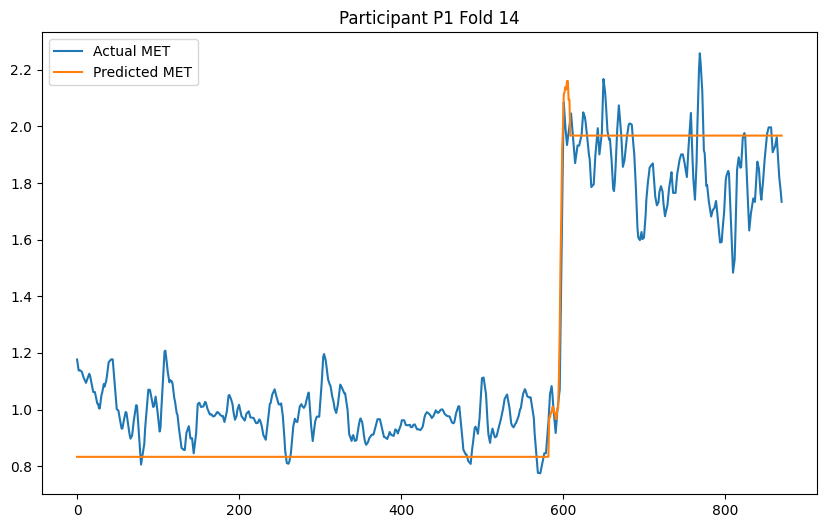

Learning rate set to 0.068408
0:	learn: 2.0203934	total: 7.59ms	remaining: 7.59s
1:	learn: 1.9272011	total: 12.3ms	remaining: 6.13s
2:	learn: 1.8426285	total: 20.9ms	remaining: 6.93s
3:	learn: 1.7664751	total: 33.3ms	remaining: 8.29s
4:	learn: 1.6970364	total: 41ms	remaining: 8.15s
5:	learn: 1.6343272	total: 47.1ms	remaining: 7.8s
6:	learn: 1.5775808	total: 55.4ms	remaining: 7.85s
7:	learn: 1.5265423	total: 66.5ms	remaining: 8.25s
8:	learn: 1.4813198	total: 74.5ms	remaining: 8.2s
9:	learn: 1.4403831	total: 80.5ms	remaining: 7.97s
10:	learn: 1.4043153	total: 88.7ms	remaining: 7.98s
11:	learn: 1.3716960	total: 98.7ms	remaining: 8.12s
12:	learn: 1.3427692	total: 110ms	remaining: 8.38s
13:	learn: 1.3175634	total: 117ms	remaining: 8.26s
14:	learn: 1.2948114	total: 130ms	remaining: 8.53s
15:	learn: 1.2750753	total: 139ms	remaining: 8.54s
16:	learn: 1.2572987	total: 151ms	remaining: 8.72s
17:	learn: 1.2416261	total: 173ms	remaining: 9.43s
18:	learn: 1.2279208	total: 187ms	remaining: 9.67s
19:

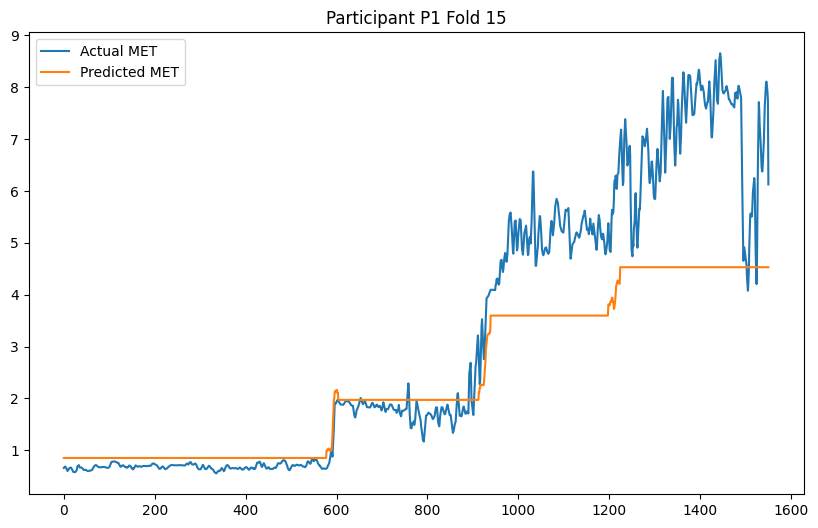

Learning rate set to 0.068558
0:	learn: 2.0535694	total: 5.34ms	remaining: 5.33s
1:	learn: 1.9579372	total: 9.86ms	remaining: 4.92s
2:	learn: 1.8710727	total: 14.6ms	remaining: 4.85s
3:	learn: 1.7922194	total: 18.8ms	remaining: 4.68s
4:	learn: 1.7208100	total: 23.4ms	remaining: 4.66s
5:	learn: 1.6562966	total: 27.7ms	remaining: 4.59s
6:	learn: 1.5979857	total: 32.2ms	remaining: 4.57s
7:	learn: 1.5456275	total: 36.9ms	remaining: 4.57s
8:	learn: 1.4990226	total: 41.9ms	remaining: 4.61s
9:	learn: 1.4569979	total: 48.5ms	remaining: 4.8s
10:	learn: 1.4198221	total: 53.3ms	remaining: 4.79s
11:	learn: 1.3863635	total: 57.9ms	remaining: 4.77s
12:	learn: 1.3566132	total: 62.8ms	remaining: 4.77s
13:	learn: 1.3307038	total: 67.1ms	remaining: 4.73s
14:	learn: 1.3078364	total: 71.4ms	remaining: 4.68s
15:	learn: 1.2874995	total: 76.6ms	remaining: 4.71s
16:	learn: 1.2692551	total: 81.1ms	remaining: 4.69s
17:	learn: 1.2531938	total: 85.8ms	remaining: 4.68s
18:	learn: 1.2391775	total: 90.3ms	remaining:

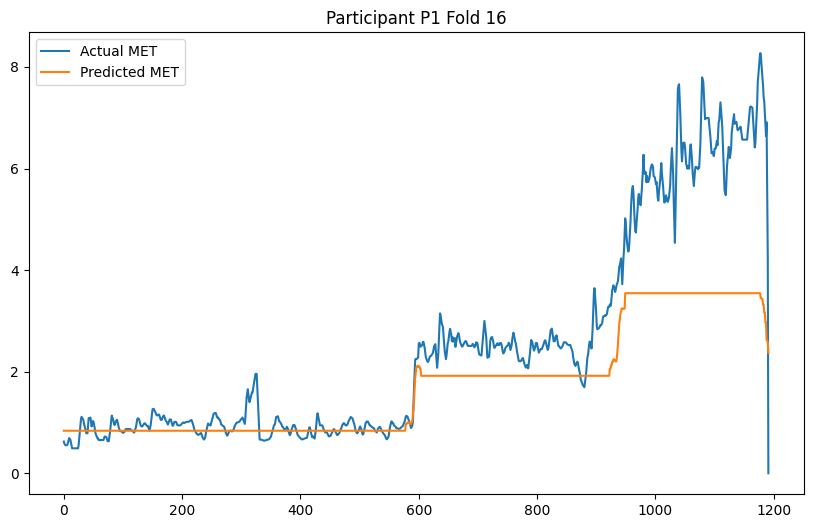

Learning rate set to 0.068307
0:	learn: 1.9622130	total: 10ms	remaining: 10s
1:	learn: 1.8727851	total: 21.7ms	remaining: 10.8s
2:	learn: 1.7919111	total: 35.9ms	remaining: 11.9s
3:	learn: 1.7189504	total: 43.7ms	remaining: 10.9s
4:	learn: 1.6523874	total: 55.8ms	remaining: 11.1s
5:	learn: 1.5923202	total: 64.3ms	remaining: 10.6s
6:	learn: 1.5380105	total: 72.1ms	remaining: 10.2s
7:	learn: 1.4891187	total: 84.8ms	remaining: 10.5s
8:	learn: 1.4457611	total: 101ms	remaining: 11.1s
9:	learn: 1.4083119	total: 112ms	remaining: 11.1s
10:	learn: 1.3732366	total: 123ms	remaining: 11.1s
11:	learn: 1.3420351	total: 132ms	remaining: 10.8s
12:	learn: 1.3145316	total: 138ms	remaining: 10.5s
13:	learn: 1.2897890	total: 143ms	remaining: 10.1s
14:	learn: 1.2681089	total: 148ms	remaining: 9.7s
15:	learn: 1.2490980	total: 156ms	remaining: 9.58s
16:	learn: 1.2323330	total: 162ms	remaining: 9.36s
17:	learn: 1.2173369	total: 168ms	remaining: 9.14s
18:	learn: 1.2040765	total: 178ms	remaining: 9.18s
19:	lear

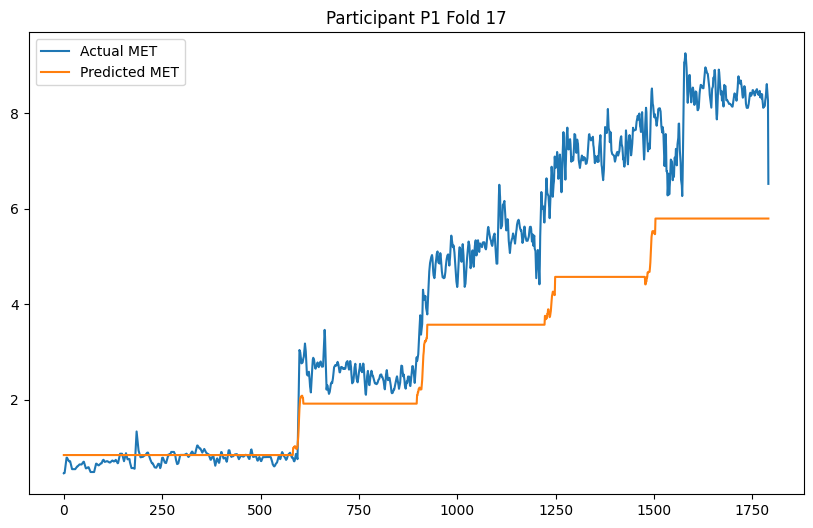

In [112]:
import matplotlib.pyplot as plt
# Import MAE
from sklearn.metrics import mean_absolute_error
# Plot the actual MET and the predicted MET for participants
# print(X_data, Y_data, participants)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    # print(train_index, test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant {0} Fold {1}'.format(people[fold], fold+1))
    plt.legend()
    plt.show()